## Contents of This Notebook

Click on the section and go to this cell immediately.

* [Section 1. Explore Data](#section_1)
* [Section 2. Identifying Stationarity](#section_2)
* [Section 3. Nonstationary-to-Stationary Transformations](#section_3)
* [Section 4. Smoothing Techniques and Models](#section_4)
* [Section 5. Training and Validation ARIMA models](#section_5)
* [Conclusion](#conclusion)


Before running this notebook please run next commands:
* pip install -r requirements.txt

When you use Run All button with this notebook, you should wait approx. 5 mins to get output of all cells.

## General Configuration

In [12]:
import os
import sys
import math
import sklearn
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as ss
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime, date, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from utils import run_simple_sequence_plot
from constants import *

In [13]:
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

## Python & Library Versions

In [14]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.4
statsmodels 0.12.2
seaborn     0.11.2
sklearn     1.0.2


## Inspect Dataset

In [15]:
hourly_radiation_df = pd.read_csv(os.path.join("..", "data", "dataset1_HourlySolarRadiationProcessed.csv"))
hourly_radiation_df.head()

Hourly_DateTime  Radiation  Temperature  Pressure  Humidity  \
0  2016-10-01 00:00:00       1.26        48.50     30.45     88.25   
1  2016-10-01 01:00:00       1.27        50.42     30.44     98.92   
2  2016-10-01 02:00:00       1.28        50.08     30.43    100.00   
3  2016-10-01 03:00:00       1.27        50.17     30.43    100.00   
4  2016-10-01 04:00:00       1.27        50.17     30.43    100.17   

   WindDirection(Degrees)  Speed  ZenithDeviation  Year  Month  Day  Hour  \
0                  153.25   9.98           697.62  2016     10    1     0   
1                  145.18   8.06           644.50  2016     10    1     1   
2                  136.54   6.84           584.50  2016     10    1     2   
3                  132.10   5.34           524.50  2016     10    1     3   
4                  117.02   6.75           464.50  2016     10    1     4   

   Log_Radiation  
0           0.23  
1           0.24  
2           0.24  
3           0.24  
4           0.24

In [16]:
hourly_radiation_df.columns

Index(['Hourly_DateTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'ZenithDeviation', 'Year', 'Month',
       'Day', 'Hour', 'Log_Radiation'],
      dtype='object')

In [17]:
print(f'Data time range: from {hourly_radiation_df.Hourly_DateTime.unique().min()} to {hourly_radiation_df.Hourly_DateTime.unique().max()}')

Data time range: from 2016-10-01 00:00:00 to 2016-11-29 00:00:00


In [18]:
hourly_radiation_df.index = hourly_radiation_df.Hourly_DateTime

<a id='section_1'></a>
## Section 1. Identifying Stationarity

In [19]:
def run_sequence_plot(df, y_column, title, from_datetime=None, to_datetime=None):
    if not from_datetime:
        from_datetime = df.index.min()
    if not to_datetime:
        to_datetime = df.index.max()

    plt.plot(df[from_datetime: to_datetime].index, df[y_column][from_datetime: to_datetime].values,
             color='blue', label="Radiation")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

In [20]:
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [All period]')

KeyboardInterrupt: 

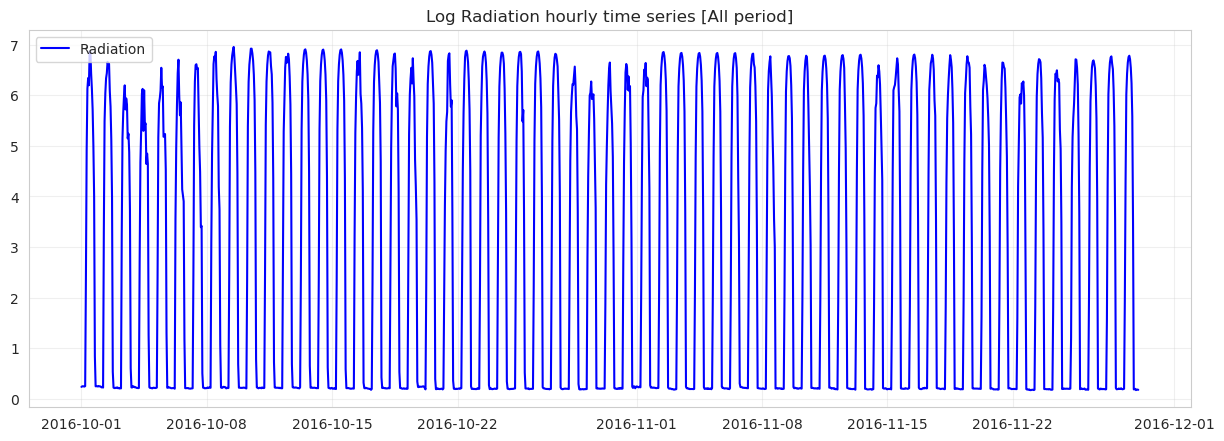

In [20]:
run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [All period]')

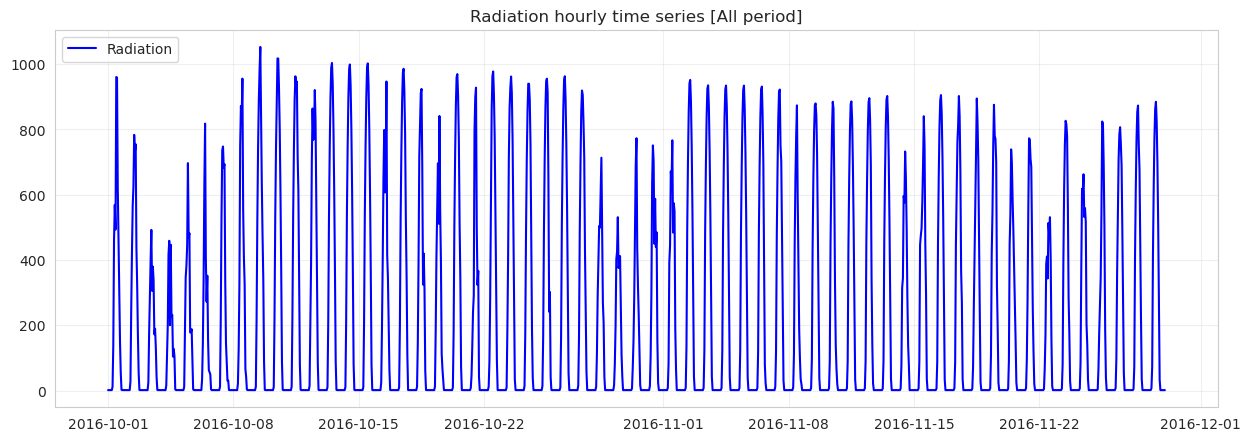

In [21]:
run_sequence_plot(hourly_radiation_df[datetime(2016, 10, 1, 0, 0, 0): datetime(2016, 12, 1, 0, 0, 0)],
                  'Radiation', 'Radiation hourly time series [All period]')

In [22]:
hourly_radiation_df[datetime(2016, 10, 1, 0, 0, 0): datetime(2016, 12, 1, 0, 0, 0)].tail(20)

Radiation  Temperature   Pressure   Humidity  \
Hourly_DateTime                                                      
2016-11-28 05:00:00    1.213333    44.250000  30.436667  25.916667   
2016-11-28 06:00:00    6.864167    45.250000  30.448333  23.333333   
2016-11-28 07:00:00   72.420833    45.083333  30.452500  53.916667   
2016-11-28 08:00:00  410.825833    54.416667  30.460833  23.916667   
2016-11-28 09:00:00  618.345000    57.250000  30.469167  46.916667   
2016-11-28 10:00:00  773.941667    57.916667  30.462500  52.250000   
2016-11-28 11:00:00  862.703333    60.166667  30.458333  35.500000   
2016-11-28 12:00:00  884.855833    61.000000  30.446667  24.416667   
2016-11-28 13:00:00  825.655000    59.666667  30.429167  40.250000   
2016-11-28 14:00:00  697.576667    56.916667  30.410833  58.500000   
2016-11-28 15:00:00  514.175833    57.083333  30.410000  49.083333   
2016-11-28 16:00:00  266.899167    54.416667  30.419167  65.333333   
2016-11-28 17:00:00   32.553333    50.000000  30.425833  61.416667   
2016-11-28 18:00:00    1.199167    45.333333  30.433333  85.666667   
2016-11-28 19:00:00    1.201667    43.750000  30.441667  86.083333   
2016-11-28 20:00:00    1.211667    43.250000  30.451667  69.250000   
2016-11-28 21:00:00    1.181667    40.666667  30.459167  92.750000   
2016-11-28 22:00:00    1.191667    39.833333  30.460000  98.750000   
2016-11-28 23:00:00    1.195000    39.416667  30.458333  95.166667   
2016-11-29 00:00:00    1.188333    40.000000  30.452500  76.333333   

                     WindDirection(Degrees)     Speed  Sun_Day_Duration  Year  \
Hourly_DateTime                                                                 
2016-11-28 05:00:00              154.883333  6.559167             11.05  2016   
2016-11-28 06:00:00              152.550000  6.091667             11.05  2016   
2016-11-28 07:00:00              144.216667  5.997500             11.05  2016   
2016-11-28 08:00:00              133.224167  8.060833             11.05  2016   
2016-11-28 09:00:00               90.109167  5.246667             11.05  2016   
2016-11-28 10:00:00               97.339167  5.716667             11.05  2016   
2016-11-28 11:00:00               88.712500  5.904167             11.05  2016   
2016-11-28 12:00:00               90.100833  5.997500             11.05  2016   
2016-11-28 13:00:00               62.096667  6.746667             11.05  2016   
2016-11-28 14:00:00               59.493333  4.216667             11.05  2016   
2016-11-28 15:00:00              128.230833  3.560833             11.05  2016   
2016-11-28 16:00:00              119.996667  3.747500             11.05  2016   
2016-11-28 17:00:00              132.315833  5.998333             11.05  2016   
2016-11-28 18:00:00              123.000000  7.779167             11.05  2016   
2016-11-28 19:00:00              138.250833  7.121667             11.05  2016   
2016-11-28 20:00:00              115.408333  5.060000             11.05  2016   
2016-11-28 21:00:00              125.250833  8.154167             11.05  2016   
2016-11-28 22:00:00              132.780833  8.340833             11.05  2016   
2016-11-28 23:00:00              149.800000  6.279167             11.05  2016   
2016-11-29 00:00:00              133.470000  6.653333             11.03  2016   

                     Month  Day  Hour  Day_of_week  Weekend  Log_Radiation  
Hourly_DateTime                                                             
2016-11-28 05:00:00     11   28     5            0        0       0.193371  
2016-11-28 06:00:00     11   28     6            0        0       1.926315  
2016-11-28 07:00:00     11   28     7            0        0       4.282494  
2016-11-28 08:00:00     11   28     8            0        0       6.018169  
2016-11-28 09:00:00     11   28     9            0        0       6.427047  
2016-11-28 10:00:00     11   28    10            0        0       6.651497  
2016-11-28 11:00:00     11   28    11            0        0       6.760071  
2016-

In [23]:
hourly_radiation_df = hourly_radiation_df[datetime(2016, 10, 1, 0, 0, 0): datetime(2016, 11, 28, 23, 0, 0)]
daily_radiation_df = daily_radiation_df[date(2016, 10, 1): date(2016, 11, 28)]

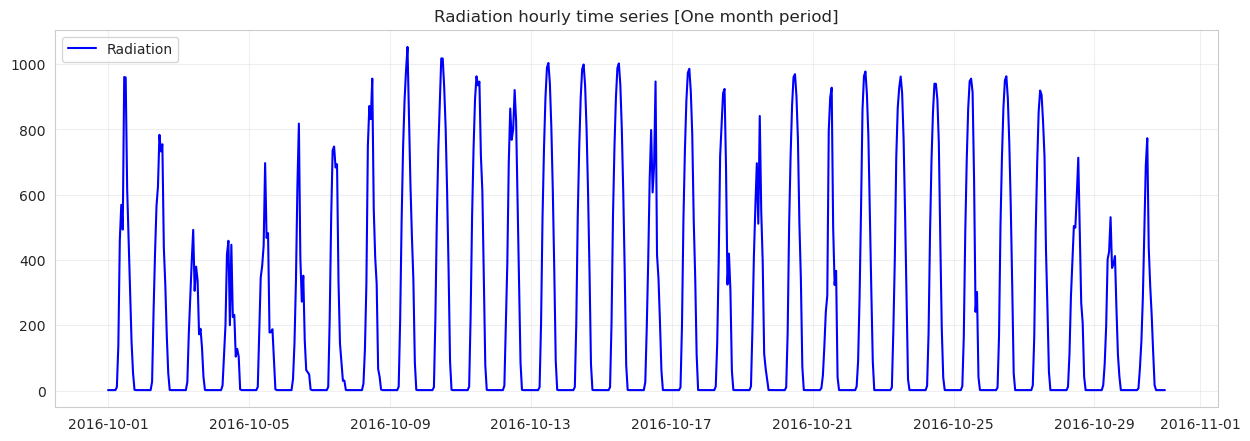

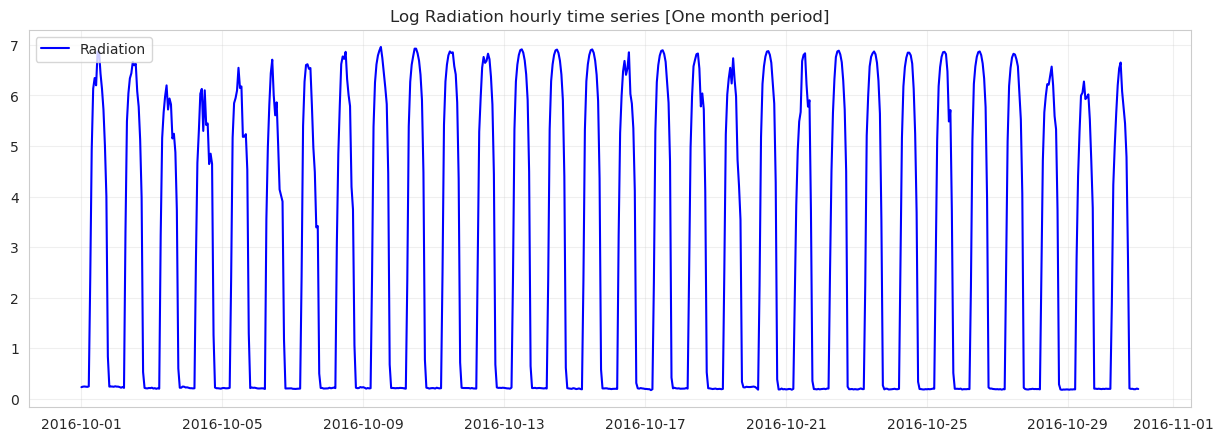

In [24]:
from_datetime = datetime(year=2016, month=10, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One month period]',
                  from_datetime=from_datetime,
                  to_datetime=from_datetime + timedelta(days=30))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One month period]',
                  from_datetime=from_datetime,
                  to_datetime=from_datetime + timedelta(days=30))

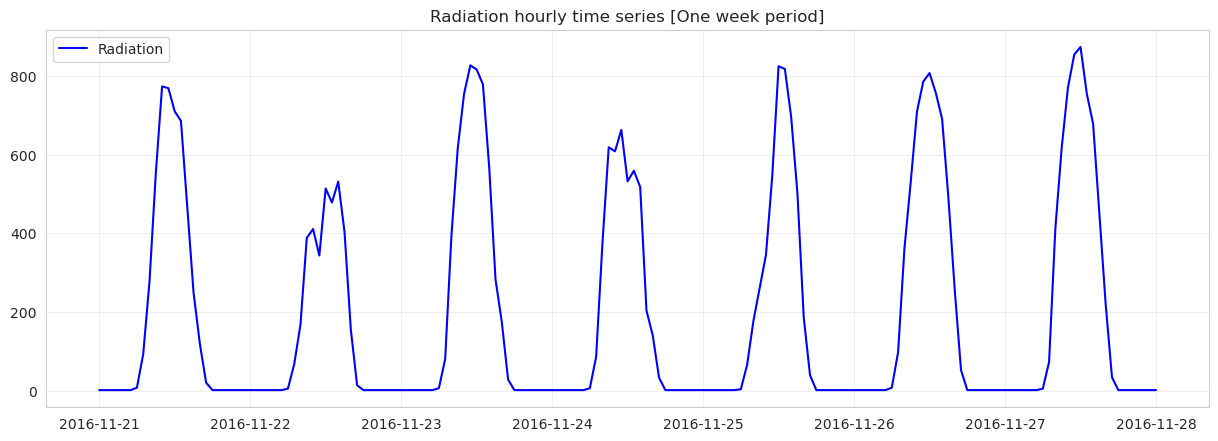

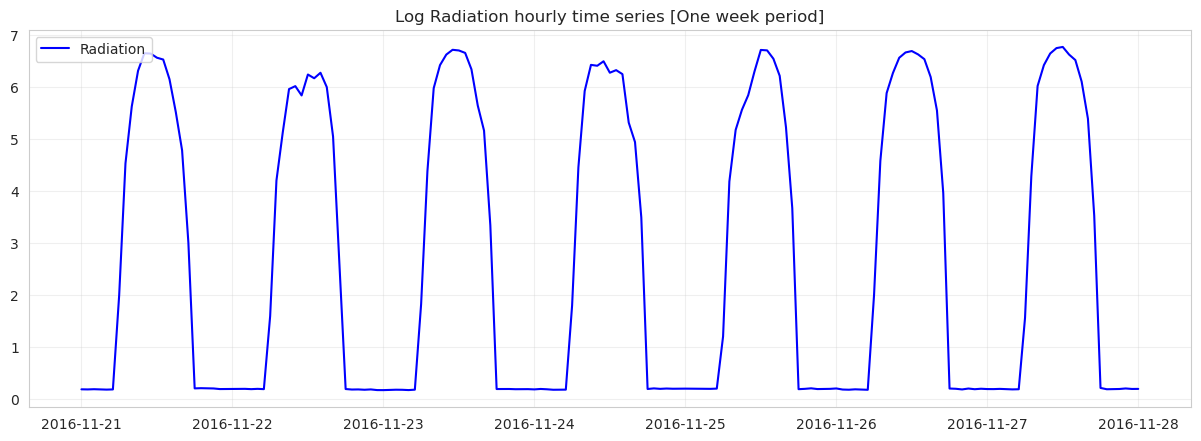

In [25]:
from_datetime = datetime(year=2016, month=11, day=21, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One week period]',
                  from_datetime=from_datetime,
                  to_datetime=from_datetime + timedelta(days=7))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One week period]',
                  from_datetime=from_datetime,
                  to_datetime=from_datetime + timedelta(days=7))

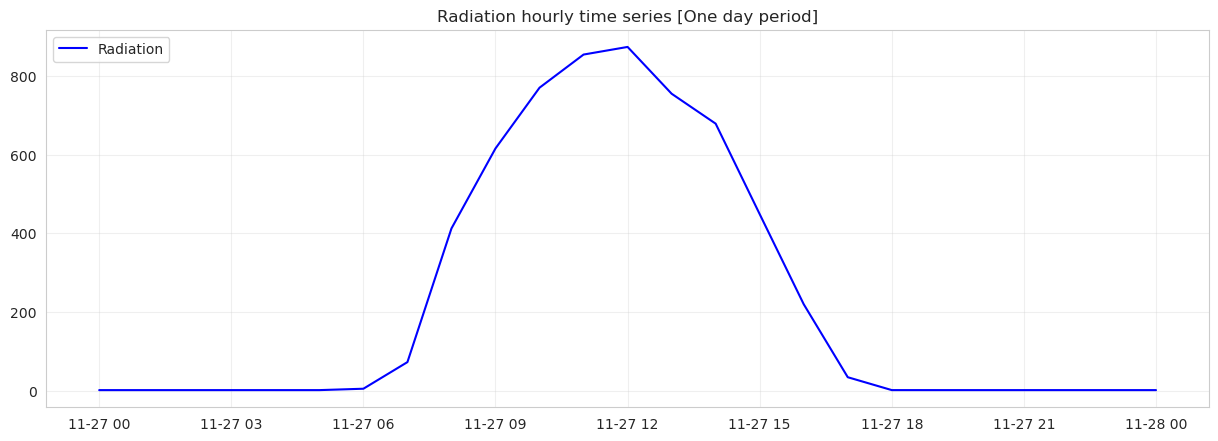

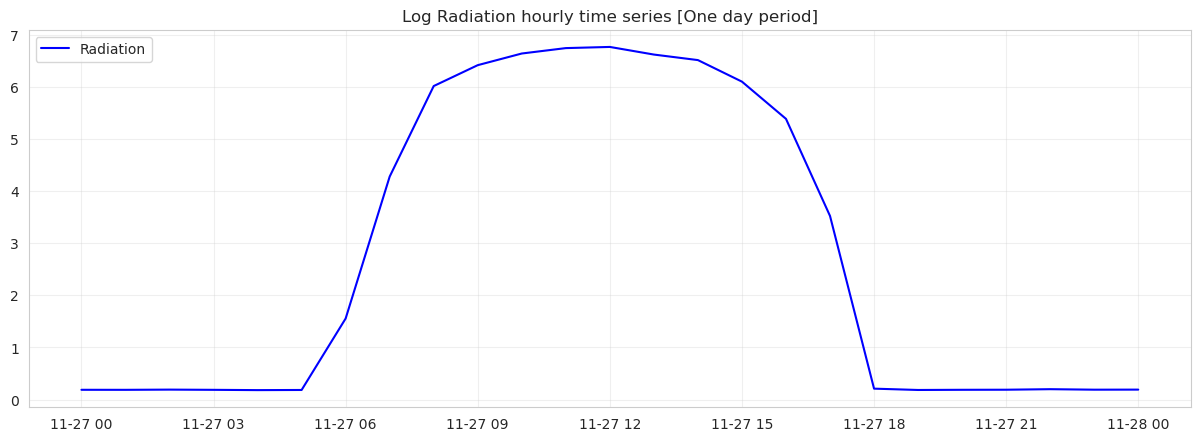

In [26]:
from_datetime = datetime(year=2016, month=11, day=27, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One day period]',
                  from_datetime=from_datetime,
                  to_datetime=from_datetime + timedelta(days=1))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One day period]',
                  from_datetime=from_datetime,
                  to_datetime=from_datetime + timedelta(days=1))

### Summary Statistics & Plots (additive hypothesis)

First way to check for constant mean and variance is to chop up the data into separate chunks, calculate statistics for each chunk, and compare

In [27]:
hourly_radiation_df.head()

Radiation  Temperature   Pressure    Humidity  \
Hourly_DateTime                                                      
2016-10-01 00:00:00   1.260000    48.500000  30.452500   88.250000   
2016-10-01 01:00:00   1.272500    50.416667  30.443333   98.916667   
2016-10-01 02:00:00   1.276667    50.083333  30.431667  100.000000   
2016-10-01 03:00:00   1.272500    50.166667  30.430000  100.000000   
2016-10-01 04:00:00   1.267500    50.166667  30.431667  100.166667   

                     WindDirection(Degrees)     Speed  Sun_Day_Duration  Year  \
Hourly_DateTime                                                                 
2016-10-01 00:00:00              153.245000  9.981250             11.97  2016   
2016-10-01 01:00:00              145.180000  8.060000             11.97  2016   
2016-10-01 02:00:00              136.536667  6.841667             11.97  2016   
2016-10-01 03:00:00              132.098333  5.343333             11.97  2016   
2016-10-01 04:00:00              117.016667  6.746667             11.97  2016   

                     Month  Day  Hour  Day_of_week  Weekend  Log_Radiation  
Hourly_DateTime                                                             
2016-10-01 00:00:00     10    1     0            5        1       0.231112  
2016-10-01 01:00:00     10    1     1            5        1       0.240983  
2016-10-01 02:00:00     10    1     2            5        1       0.244253  
2016-10-01 03:00:00     10    1     3            5        1       0.240983  
2016-10-01 04:00:00     10    1     4            5        1       0.237046

In [28]:
hourly_radiation_df.shape

(1416, 14)

In [29]:
# Compare means and variances
radiation_statistics_df = pd.DataFrame()
radiation_statistics_df['Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].mean()
radiation_statistics_df['Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].var()
radiation_statistics_df[['Radiation_Mean', 'Radiation_Variance']]

Radiation_Mean  Radiation_Variance
Year Month Day                                    
2016 10    1        216.561632        97006.337104
           2        214.627031        82189.086895
           3        122.877478        25518.202565
           4        110.630942        22815.039604
           5        152.502839        42629.439536
           6        138.703142        49168.633188
           7        177.670382        76635.889576
           8        220.942004       107431.908000
           9        283.822476       141921.954827
           10       300.962126       154926.217930
           11       292.543865       145274.052209
           12       270.945390       125591.066822
           13       300.712876       154602.587385
           14       299.648368       153784.040670
           15       299.480711       154320.138064
           16       222.966357        93047.163171
           17       292.304418       147017.373948
           18       238.781285       109621.426046
           19       183.265208        71604.341671
           20       284.465104       142455.114635
           21       191.275069        90460.578698
           22       266.118273       137098.196253
           23       275.676654       139738.500935
           24       269.280227       136267.477549
           25       262.495271       133665.921839
           26       282.662232       141854.949453
           27       263.943267       126719.996031
           28       172.972465        55157.240890
           29       135.494687        33488.163742
           30       150.367636        54182.640938
           31       194.323977        71973.797102
     11    1        203.060249        74501.149462
           2        276.276806       138641.567548
           3        270.896140       133813.948656
           4        270.271313       133413.779111
           5        269.357273       132695.004093
           6        251.908958       129655.147352
           7        257.207847       123394.820836
           8        176.269514        79630.463255
           9        254.457847       121025.146257
           10       206.548368       100997.250246
           11       252.373681       119410.574717
           12       242.450694       119738.309346
           13       257.938299       124066.296042
           14       179.551215        63042.900139
           15       215.356111        84355.513851
           16       258.962595       125135.871725
           17       242.101424       111936.919060
           18       216.231910        95801.913442
           19       229.307465       103571.860091
           20       184.269890        66551.556964
           21       197.457847        83191.808219
           22       145.492639        40151.867319
           23       222.474217       100461.505506
           24       181.434757        64078.207861
           25       186.511411        78500.996975
           26       231.416944        98278.137431
           27       239.648333       110467.993682
           28       249.219271       117260.672114

#### Histograms

<AxesSubplot:>

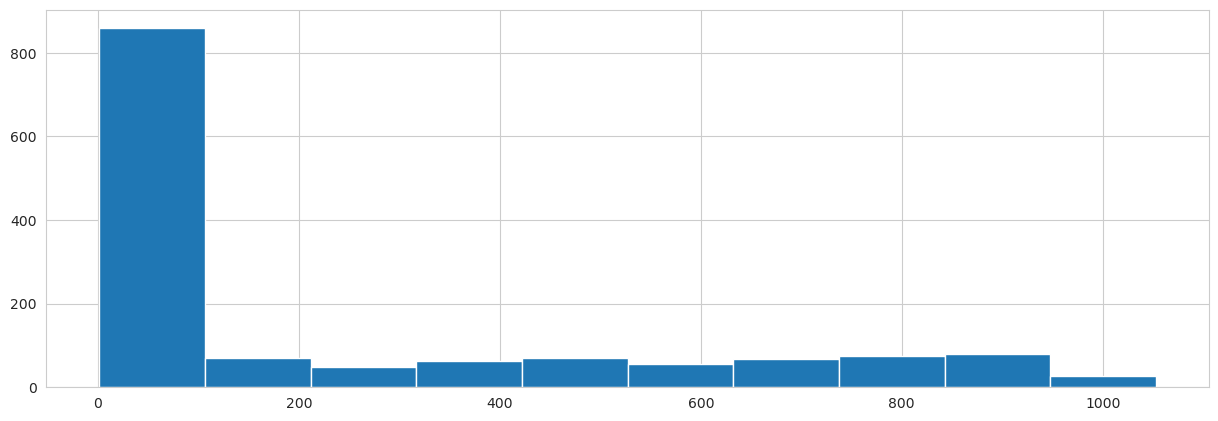

In [30]:
hourly_radiation_df.Radiation.hist()

<AxesSubplot:>

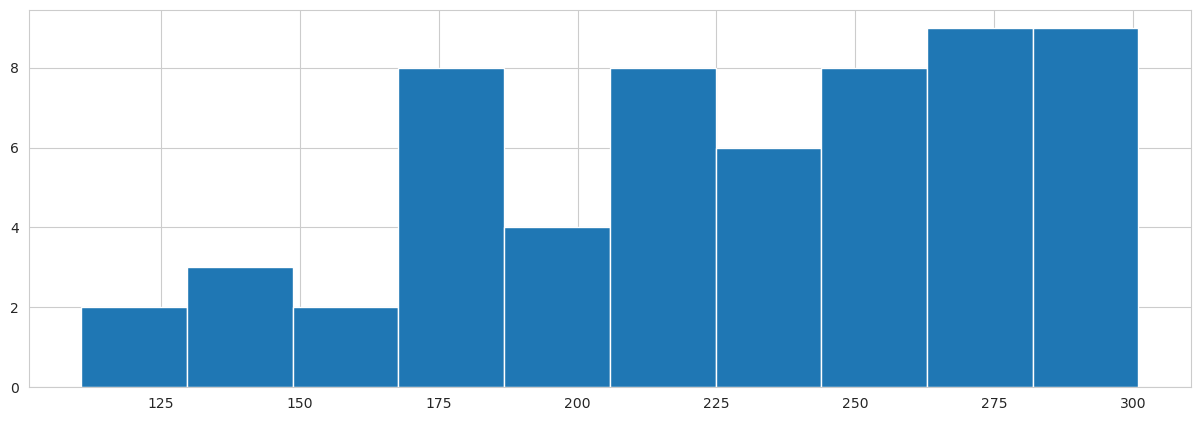

In [31]:
radiation_statistics_df['Radiation_Mean'].hist()

<AxesSubplot:>

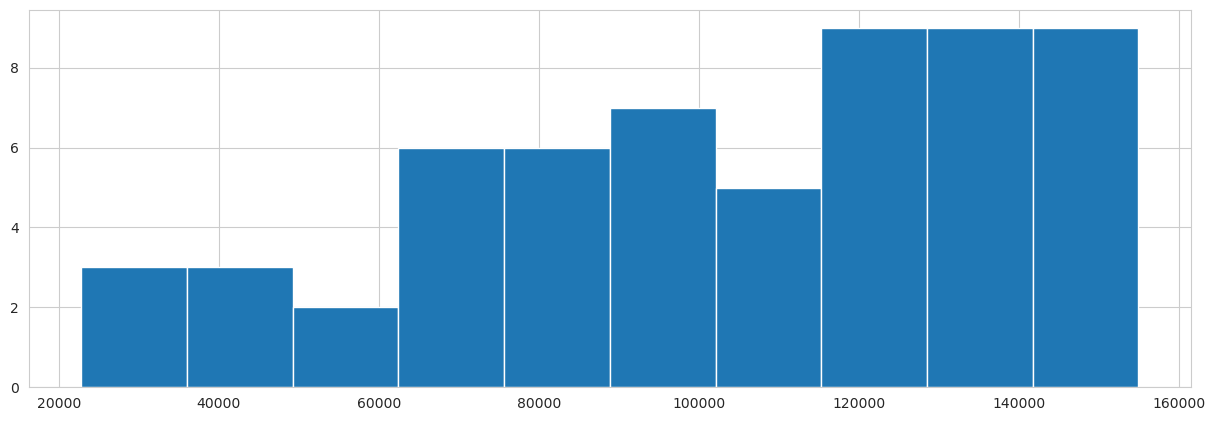

In [32]:
radiation_statistics_df['Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

What you need to know:
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.
> The value 0.05 is common but depends upons numerous factors.

In [33]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df['Radiation'], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -3.2137452004800733
p-value: 0.0192027123908175


In [34]:
def test_stationarity(df, ts_column):
    # Determining rolling statistics
    rolmean = df[ts_column].rolling(window=12, center=False).mean()
    rolstd = df[ts_column].rolling(window=12, center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts_column], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts_column], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic',
                                'p-value',
                                '# Lags Used',
                                'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

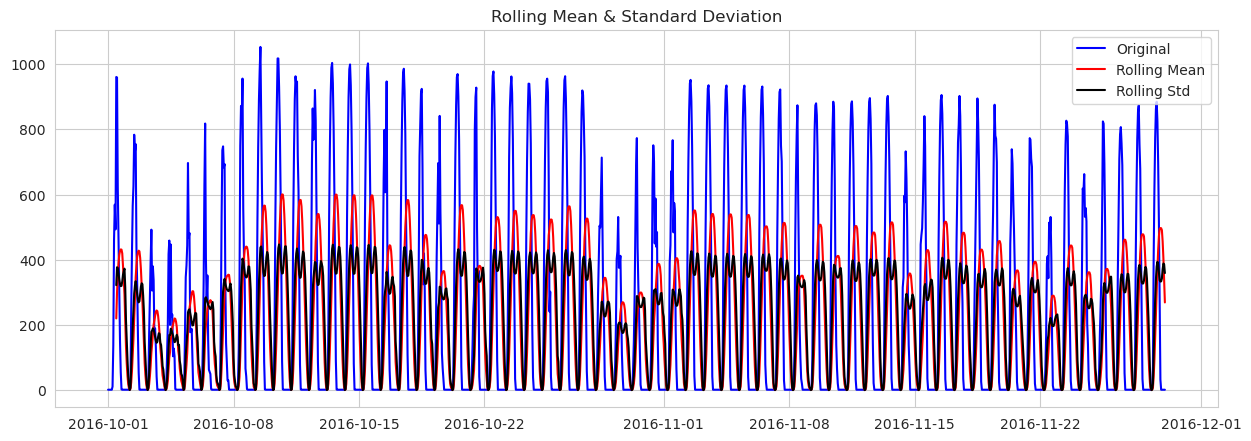

Results of Dickey-Fuller Test:
Test Statistic                   -3.213745
p-value                           0.019203
# Lags Used                      24.000000
Number of Observations Used    1391.000000
Critical Value (1%)              -3.435060
Critical Value (5%)              -2.863620
Critical Value (10%)             -2.567877
dtype: float64


In [35]:
test_stationarity(hourly_radiation_df, 'Radiation')

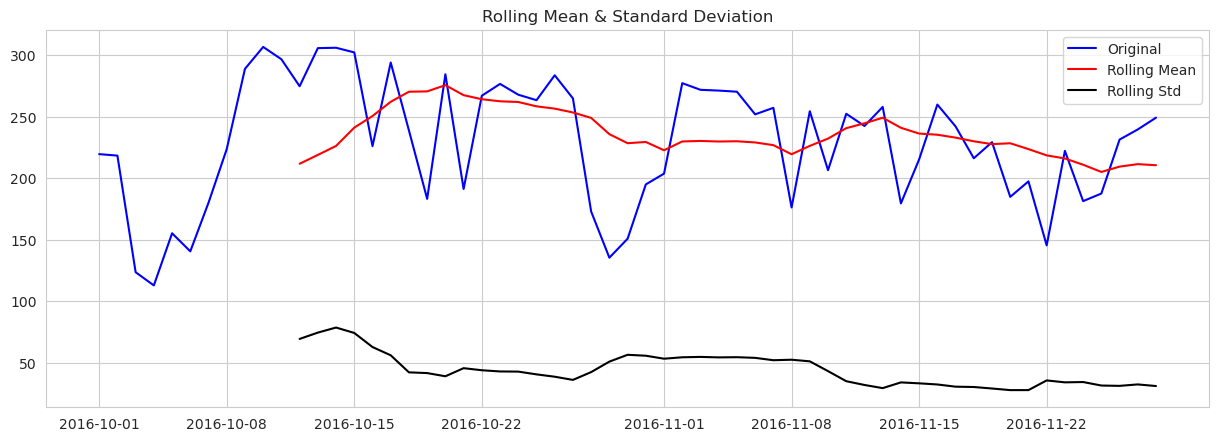

Results of Dickey-Fuller Test:
Test Statistic                 -2.825661
p-value                         0.054701
# Lags Used                     1.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [36]:
test_stationarity(daily_radiation_df, 'Radiation')

#### Explanation (additive hypothesis)

Based on [this resource](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

Based on histograms and augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
Therefore, our data is **stationary**.

----
It seems that the time series is non-stationary, since we do not have constant mean and variance + for hourly splitted time series there is periodic component. Sync with Andriy about that

### Summary Statistics & Plots (multiplicative hypothesis)

In [37]:
# Compare means and variances
radiation_statistics_df['Log_Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])[
    'Log_Radiation'].mean()
radiation_statistics_df['Log_Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])[
    'Log_Radiation'].var()

#### Histograms

<AxesSubplot:>

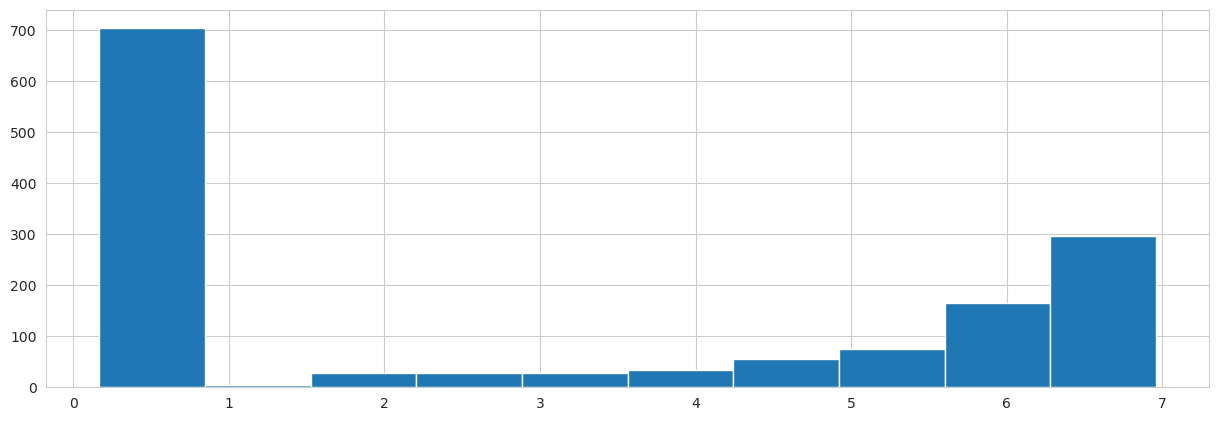

In [38]:
hourly_radiation_df.Log_Radiation.hist()

<AxesSubplot:>

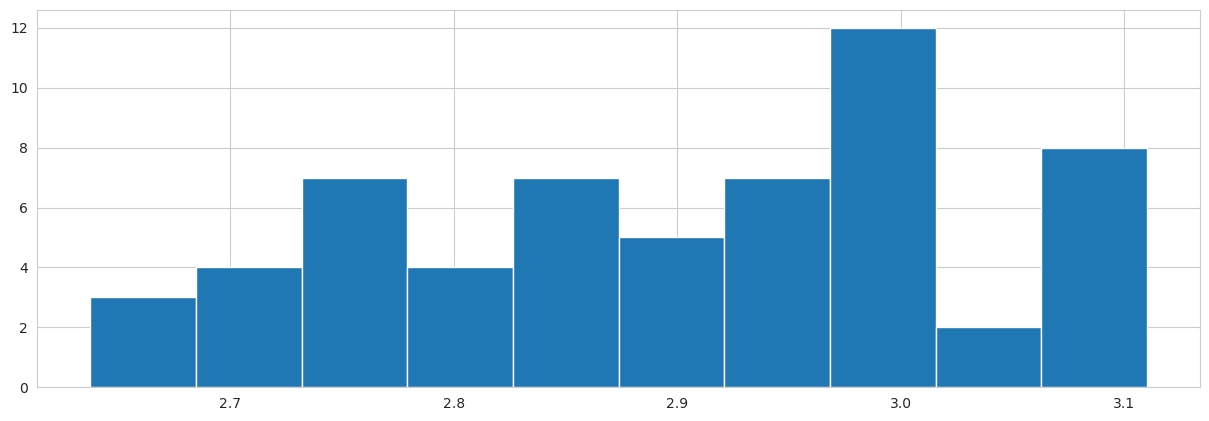

In [39]:
radiation_statistics_df['Log_Radiation_Mean'].hist()

<AxesSubplot:>

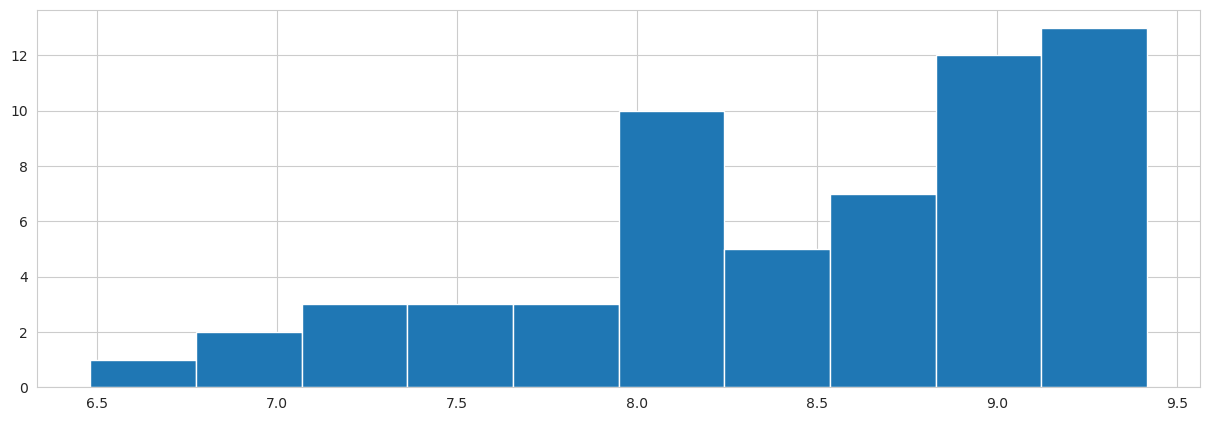

In [40]:
radiation_statistics_df['Log_Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

In [41]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df.Log_Radiation, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -3.5280101049040944
p-value: 0.0072962091474692205


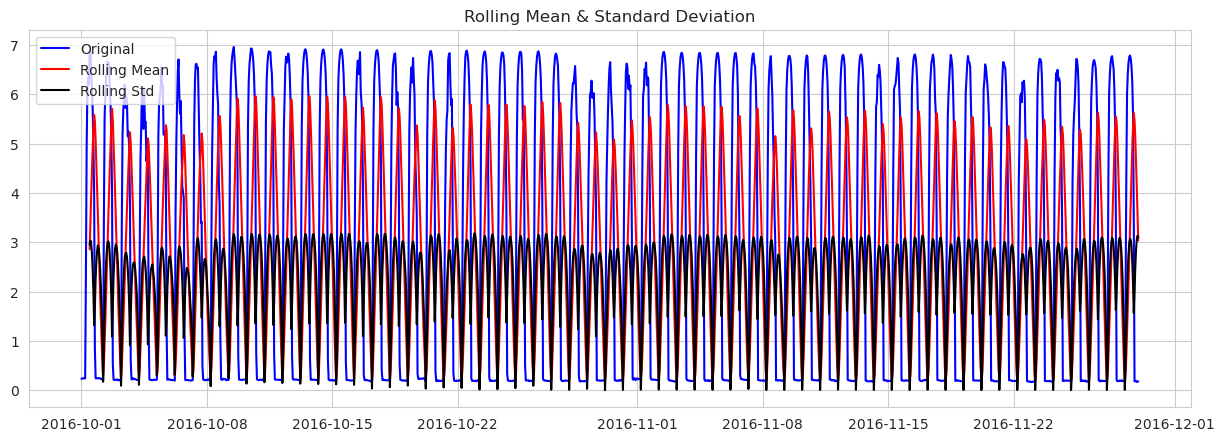

Results of Dickey-Fuller Test:
Test Statistic                   -3.528010
p-value                           0.007296
# Lags Used                      24.000000
Number of Observations Used    1391.000000
Critical Value (1%)              -3.435060
Critical Value (5%)              -2.863620
Critical Value (10%)             -2.567877
dtype: float64


In [42]:
test_stationarity(hourly_radiation_df, 'Log_Radiation')

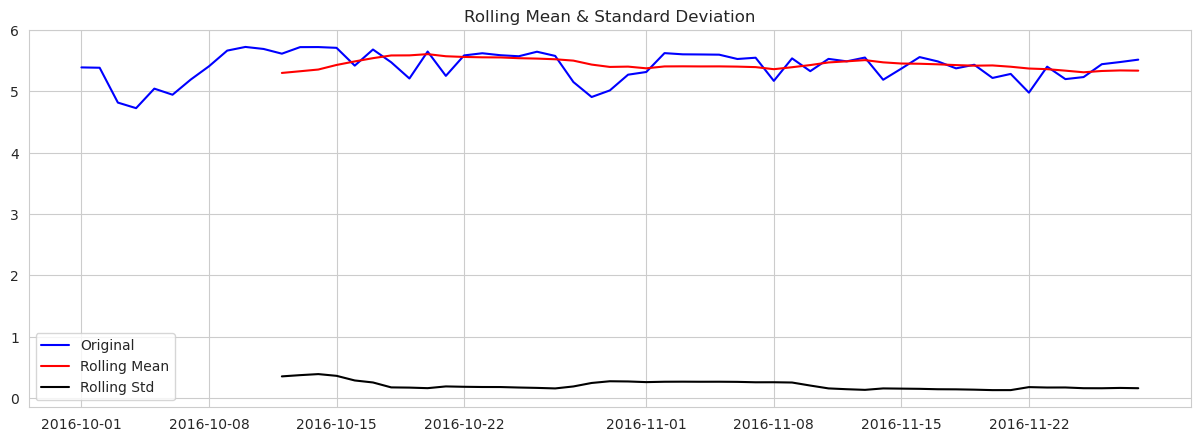

Results of Dickey-Fuller Test:
Test Statistic                 -2.918273
p-value                         0.043264
# Lags Used                     1.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [43]:
test_stationarity(daily_radiation_df, 'Log_Radiation')

#### Explanation (multiplicative hypothesis)

Based on histograms and augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
Therefore, our data is **stationary**.

<a id='section_3'></a>
## Section 3. Nonstationary-to-Stationary Transformations

Let's create a few stationary time series from our non-stationary ones, to test, which of them will give us the best score.

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


def get_polynomial_trend_prediction(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=3)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.show()

    return polynomial_trend_prediction.flatten()

### Approach #1: Remove Trend & Seasonality with Statsmodels

#### Additive hypothesis

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ss_decomposition = seasonal_decompose(x=daily_radiation_df.Radiation, model='additive', period=FORECAST_PERIOD)
ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='additive', period=FORECAST_PERIOD)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

In [46]:
print(hourly_radiation_df.Radiation.shape[0])
print(estimated_trend.shape[0])
print(estimated_seasonal.shape[0])
print(estimated_residual.shape[0])

1416
1416
1416
1416


In [47]:
estimated_residual[:20]

Hourly_DateTime
2016-10-01 00:00:00   NaN
2016-10-01 01:00:00   NaN
2016-10-01 02:00:00   NaN
2016-10-01 03:00:00   NaN
2016-10-01 04:00:00   NaN
2016-10-01 05:00:00   NaN
2016-10-01 06:00:00   NaN
2016-10-01 07:00:00   NaN
2016-10-01 08:00:00   NaN
2016-10-01 09:00:00   NaN
2016-10-01 10:00:00   NaN
2016-10-01 11:00:00   NaN
2016-10-01 12:00:00   NaN
2016-10-01 13:00:00   NaN
2016-10-01 14:00:00   NaN
2016-10-01 15:00:00   NaN
2016-10-01 16:00:00   NaN
2016-10-01 17:00:00   NaN
2016-10-01 18:00:00   NaN
2016-10-01 19:00:00   NaN
Name: resid, dtype: float64

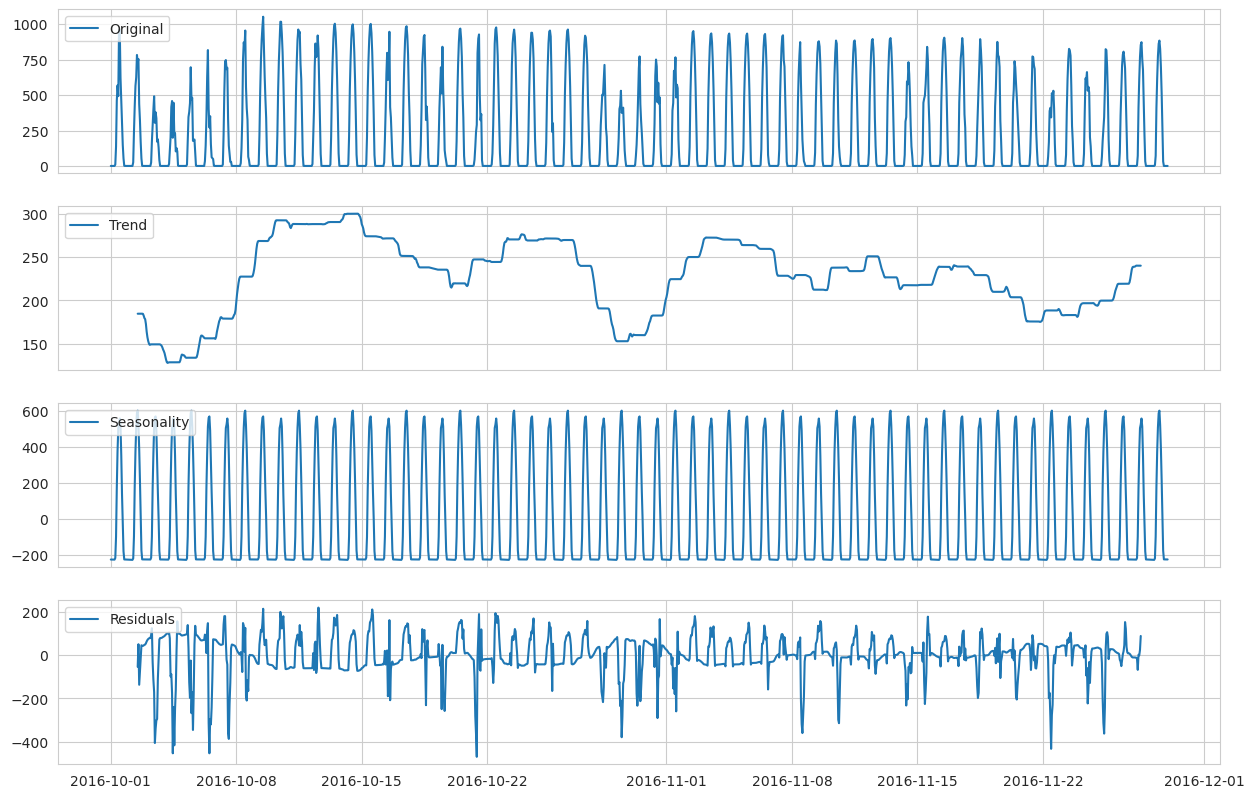

In [48]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(hourly_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left')

In [49]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -7.655496849828464
p-value:  1.7434859494153683e-11


In [50]:
additive_decomposed_radiation = estimated_residual[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT].reset_index(drop=True)
additive_decomposed_trend = estimated_trend[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT]
additive_decomposed_seasonal = estimated_seasonal

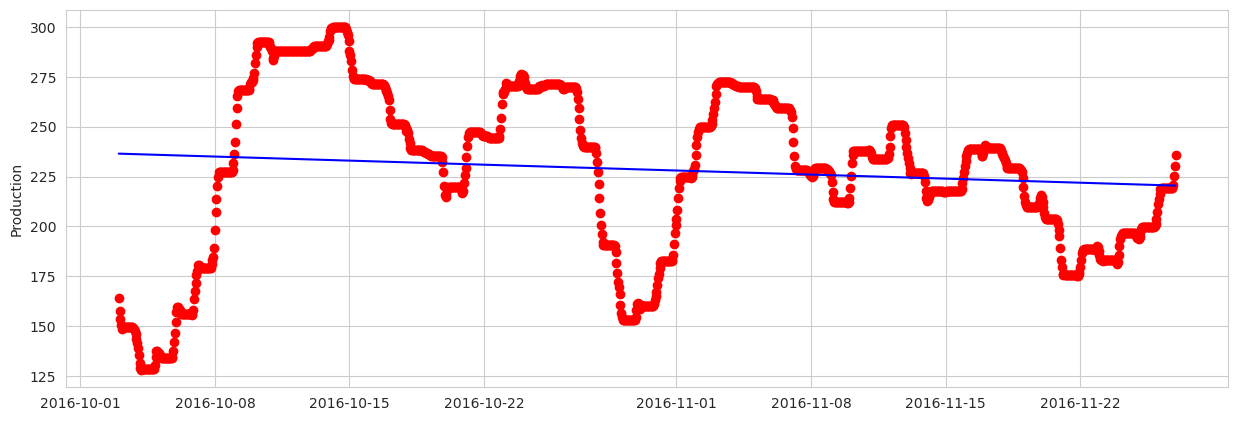

In [51]:
# predict our trent with polynomial of second degree to use it for forecast on test set
additive_decomposed_trend_prediction = get_polynomial_trend_prediction(additive_decomposed_trend)

Here are reasons why we have such a descending line of trend:
* Even if the first dataset with meteorological data from the HI-SEAS weather station (Hawai), temperature also become less in that region too.
* From other side, during the winter, the sun's rays hit the Earth at a shallow angle. These rays are more spread out, which minimizes the amount of energy
that hits any given spot. Also, the long nights and short days prevent the Earth from warming up.

#### Multiplicative hypothesis

In [52]:
# used model='multiplicative' to split on trend, seasonal and residuals
ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='multiplicative', period=FORECAST_PERIOD)
estimated_trend2 = ss_decomposition.trend
estimated_seasonal2 = ss_decomposition.seasonal
estimated_residual2 = ss_decomposition.resid

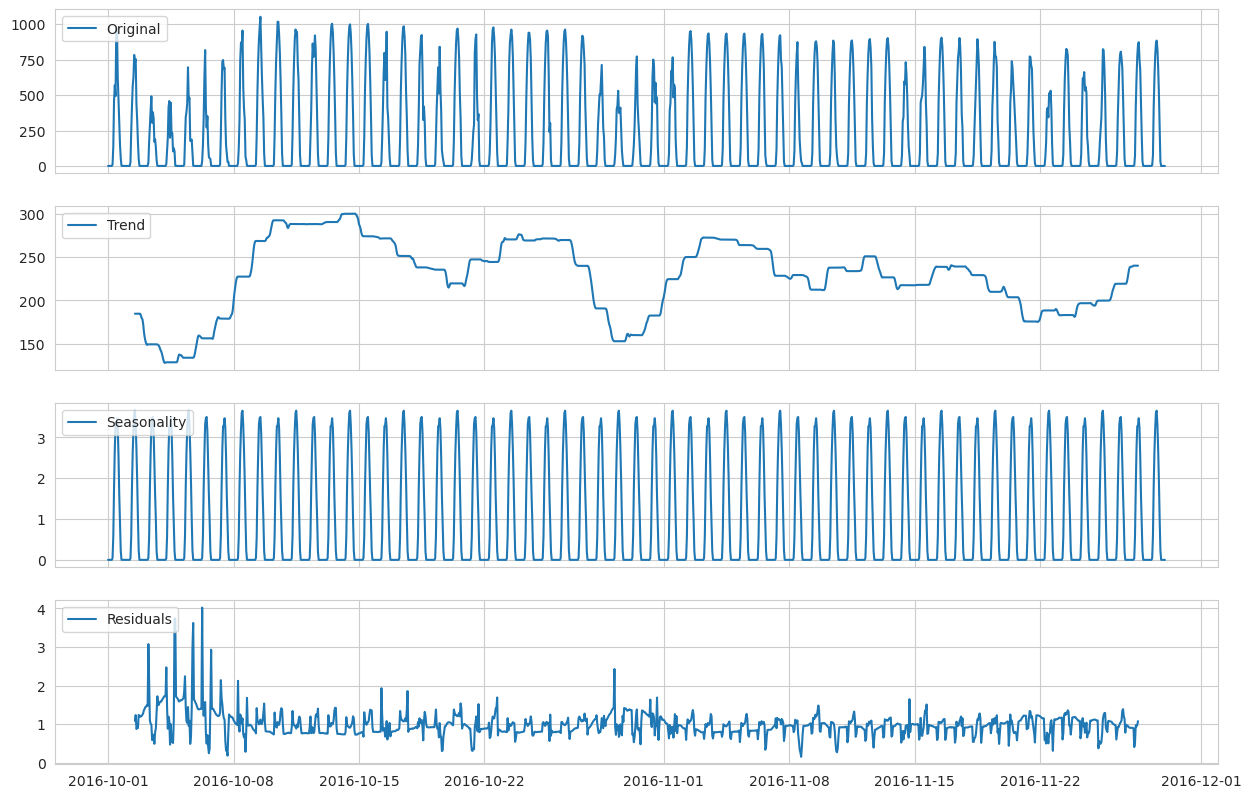

In [53]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(hourly_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend2, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal2, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual2, label='Residuals')
axes[3].legend(loc='upper left')

In [54]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual2[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -2.9464147040130015
p-value:  0.04021072656828775


In [55]:
multiplicative_decomposed_radiation = estimated_residual2[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT].reset_index(drop=True)
multiplicative_decomposed_trend = estimated_trend2[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT]
multiplicative_decomposed_seasonal = estimated_seasonal2

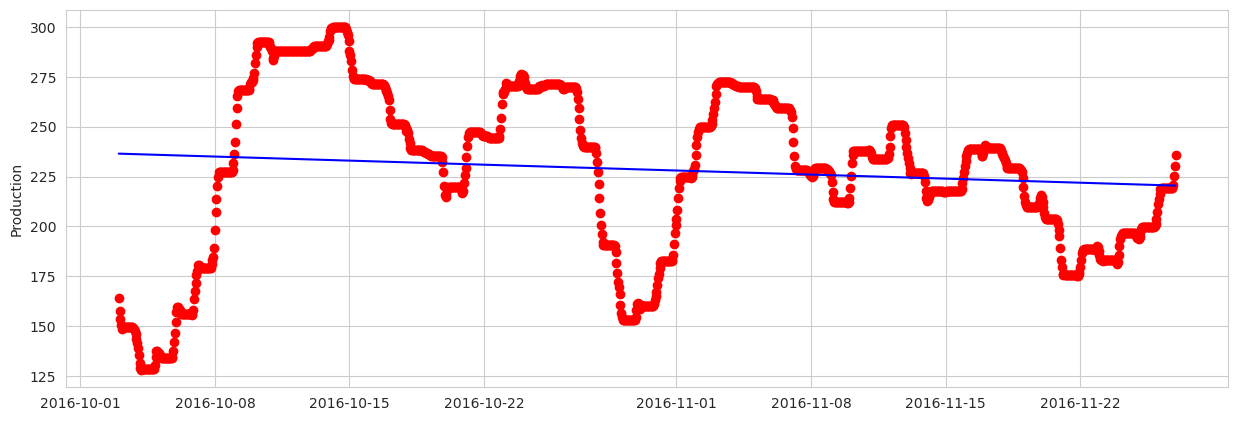

In [56]:
# predict our trent with polynomial of second degree to use it for forecast on test set
multiplicative_decomposed_trend_prediction = get_polynomial_trend_prediction(multiplicative_decomposed_trend)

#### Note!

Now **both additive_decomposed_production and multiplicative_decomposed_production are stationary**, what we can observe from plots of residuals and augmented Dickey-Fuller tests (both p-values < 0.05).

### Approach #2: Log Transformation

As our time series of multiplicative hypothesis was non-stationary, so this approach did not help to make our initial OtherPEN_production['Production'] stationary.

### Approach #3: Removing Autocorrelation with Differencing

Let's subtract $O_{t-1}$ from $O_{t}$ where $O_{t}$ is the observed data at time *t* and $O_{t-1}$ is the observed data at *t-1*.

#### Additive hypothesis

Here ew use differencing approach with lag = 1 (to reduce trend) and lag = 12 (to reduce sessonality).

##### First difference

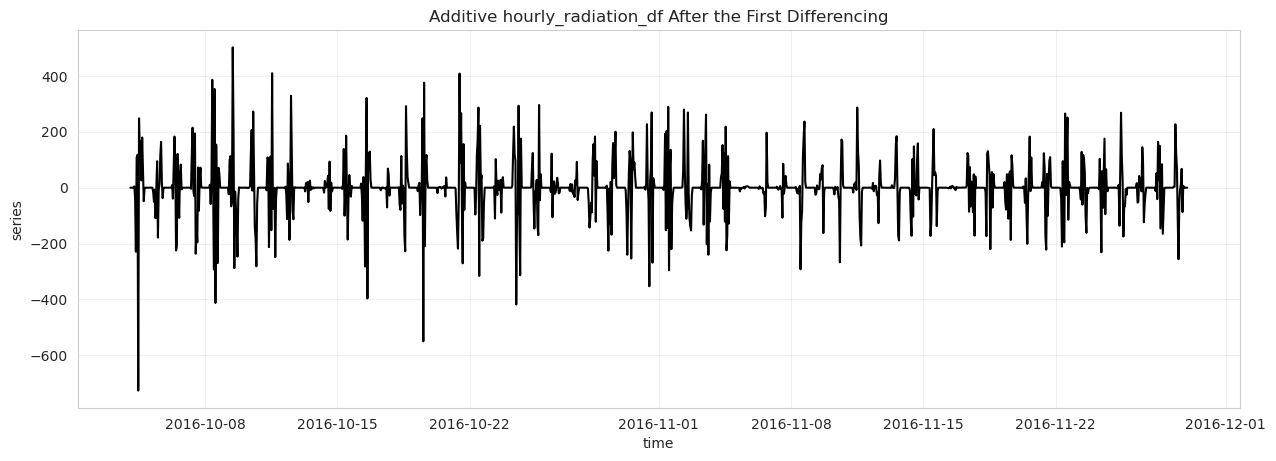

In [57]:
additive_diff_production_1 = hourly_radiation_df.Radiation.diff(FORECAST_PERIOD).diff(1)
run_simple_sequence_plot(hourly_radiation_df.index, additive_diff_production_1,
                         title="Additive hourly_radiation_df After the First Differencing")

In [58]:
additive_diff_production_1 = additive_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -14.760309058658414
p-value:  2.408020658967118e-27


##### Second difference

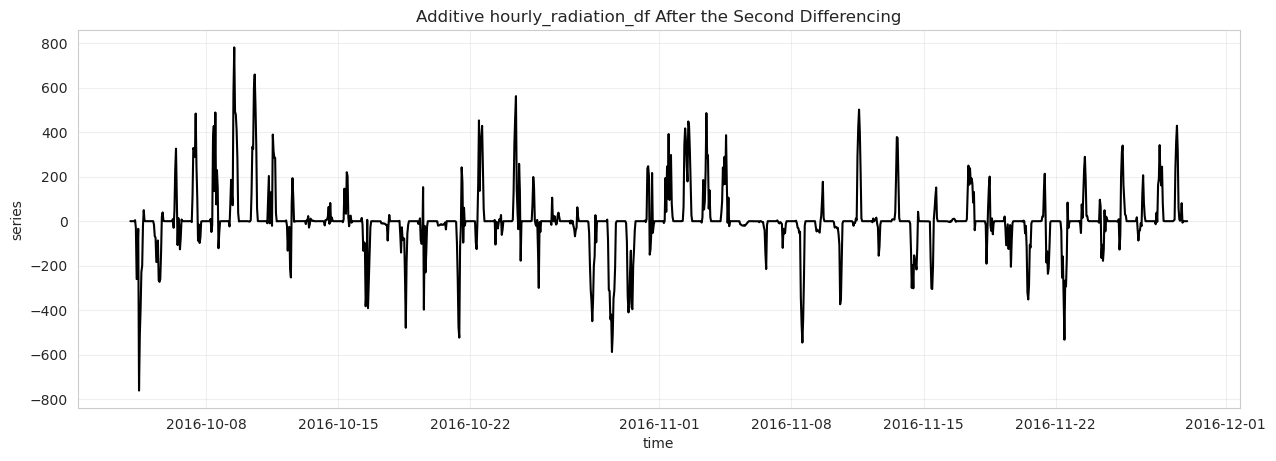

In [59]:
additive_diff_production_12 = hourly_radiation_df.Radiation.diff(FORECAST_PERIOD)
run_simple_sequence_plot(hourly_radiation_df.index, additive_diff_production_12,
                         title="Additive hourly_radiation_df After the Second Differencing")
additive_diff_production_12 = additive_diff_production_12[FORECAST_PERIOD:].reset_index(drop=True)

In [60]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -4.635418935301208
p-value:  0.00011108450814295413


#### Multiplicative hypothesis

##### First difference

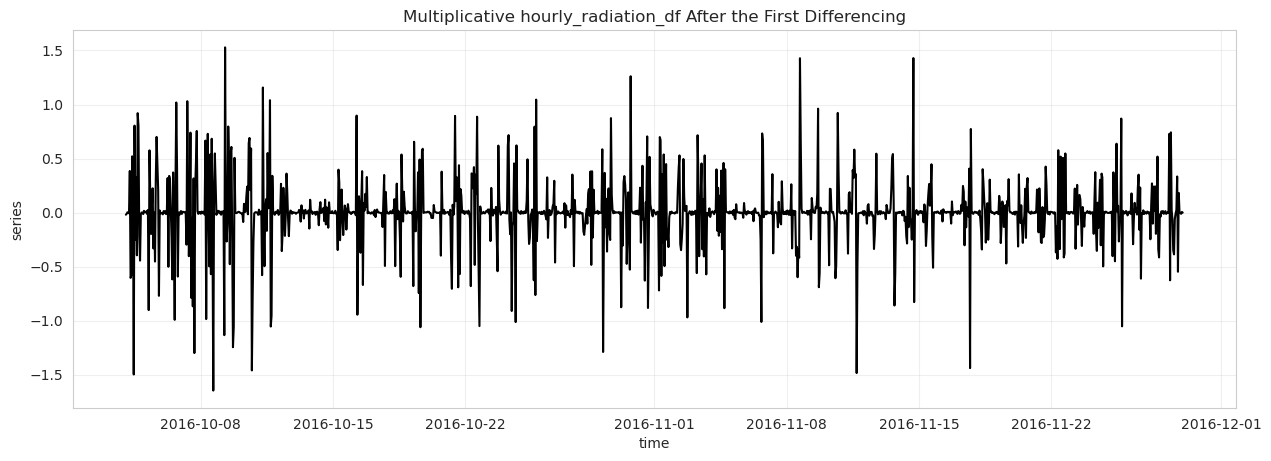

In [61]:
multiplicative_diff_production_1 = hourly_radiation_df.Log_Radiation.diff(FORECAST_PERIOD).diff(1)

run_simple_sequence_plot(hourly_radiation_df.index, multiplicative_diff_production_1,
                         title="Multiplicative hourly_radiation_df After the First Differencing")
multiplicative_diff_production_1 = multiplicative_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)

In [62]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -15.199534472254122
p-value:  5.85601596646488e-28


##### Second difference

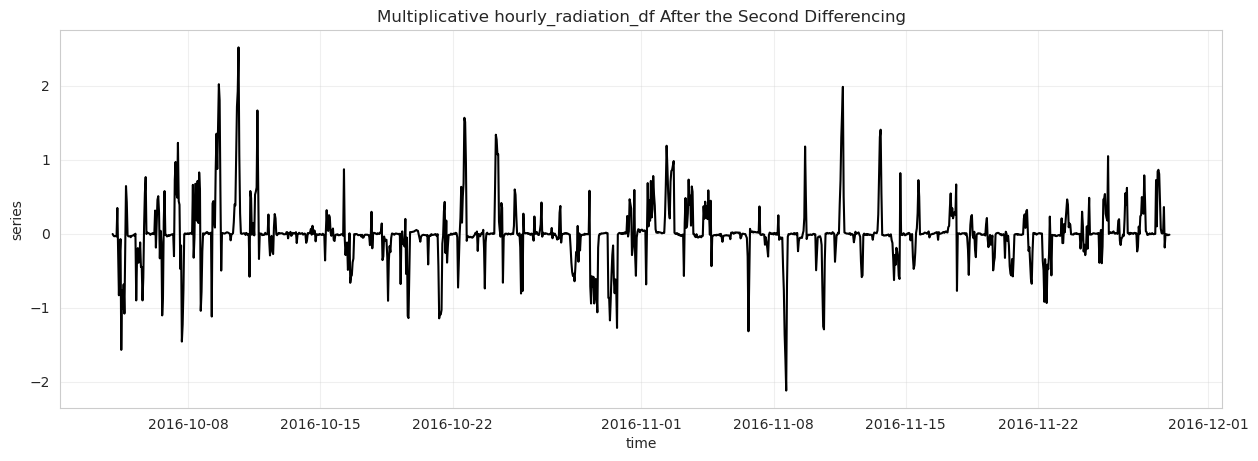

In [63]:
multiplicative_diff_production_12 = hourly_radiation_df.Log_Radiation.diff(FORECAST_PERIOD)

run_simple_sequence_plot(hourly_radiation_df.index, multiplicative_diff_production_12,
                         title="Multiplicative hourly_radiation_df After the Second Differencing")

In [64]:
multiplicative_diff_production_12 = multiplicative_diff_production_12[FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -5.307606629683756
p-value:  5.280450912551009e-06


In [65]:
data_to_return_to_initial_series = {
    'additive_decomposed_radiation': {
        'predicted_trend': additive_decomposed_trend_prediction,
        'seasonality': additive_decomposed_seasonal
    },
    'multiplicative_decomposed_radiation': {
        'predicted_trend': multiplicative_decomposed_trend_prediction,
        'seasonality': multiplicative_decomposed_seasonal
    },
    'additive_diff_production_1': {
        'lag': 1
    },
    'multiplicative_diff_production_1': {
        'lag': 1
    },
    'additive_diff_production_12': {
        'lag': FORECAST_PERIOD
    },
    'multiplicative_diff_production_12': {
        'lag': FORECAST_PERIOD
    }
}

<a id='section_5'></a>
## Section 4. Training and Validation ARIMA models

In [66]:
# Create copy of the dataframe for convenience
hourly_radiation_reset_df = hourly_radiation_df.reset_index().copy()

In [67]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt
from sklearn.model_selection import TimeSeriesSplit

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr

    return({'1. Mean Absolute Percentage Error (MAPE)':mape,
            '2. Mean Percentage Error (MPE)': mpe,
            '3. Root Mean Squared Error (RMSE)': rmse,
            '4. Mean Error (ME)': me,
            '5. Mean Absolute Error (MAE)': mae,
            '6. Correlation between the Actual and the Forecast (CORR)':corr})


"""def get_train_validate_test_split(time_series):
    ""

    :return: splits on train, validation and test sets based on Cross-Validation
    ""
    n_splits = 3 # Number of train/cv/test folds
    results = []

    trainTestSplit = TimeSeriesSplit(n_splits+1).split(time_series)
    next(trainTestSplit) # Skip the first fold

    for trainCvIndices, testIndices in trainTestSplit:
        # First, we split Train + CV and Test
        XTrainCv = time_series.iloc[trainCvIndices]
        XTest = time_series.iloc[testIndices]

        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
        testLength = len(XTest)
        train = XTrainCv.iloc[0: -testLength-1]
        validate = XTrainCv.iloc[-testLength: -1]

        results.append([train, validate, XTest, XTrainCv])

    return results"""


def get_train_validate_test_split(np_array):
    # end_shift = max(FEATURES_LAGS + RADIATION_LAGS)
    # train_lengths = [177 - end_shift, 189 - end_shift, 201 - end_shift]
    df_length = np_array.shape[0]
    validate_length = FORECAST_PERIOD # also equal to test length
    train_lengths = [df_length - 4 * validate_length, df_length - 3 * validate_length, df_length - 2 * validate_length]

    splits = []
    for train_length in train_lengths:
        train = np_array[: train_length]
        validate = np_array[train_length: train_length + validate_length]
        train_validate = np_array[:train_length + validate_length]
        test = np_array[train_length + validate_length: train_length + 2 * validate_length]

        splits.append((train, validate, test, train_validate))

    return splits


In [68]:
def return_to_initial_series_additive_differencing(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                   model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD
    lag = data_to_return_to_initial_series[stationary_series_name]['lag']

    best_ARMA_model_prediction = best_ARMA_model_prediction.reset_index(drop=True)
    ARMA_model_prediction_initial_series = []

    for i in range(lag):
        ARMA_model_prediction_initial_series.append(hourly_radiation_reset_df.Radiation[len_train_set - lag + i + DECOMPOSED_SHIFT] +
                                                    best_ARMA_model_prediction[i])

    for i in range(lag, len(best_ARMA_model_prediction)):
        ARMA_model_prediction_initial_series.append(ARMA_model_prediction_initial_series[i - lag] + \
                                                    best_ARMA_model_prediction[i])

    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].to_numpy())

    if show_plots:
        print('\n' * 2, '=' * 20, f'Forecast Accuracy on Test Set [{model_name}]', '=' * 20)
        print('Order (p, d, q) -- ', order_tpl)
        pprint(model_forecast_accuracy)

        x_indices = range(start_idx + DECOMPOSED_SHIFT, end_idx + DECOMPOSED_SHIFT)

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1], color='blue', label="train")
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT], color='orange', label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy


def return_to_initial_series_additive_decomposed(best_ARMA_model_prediction, len_train_set, order_tpl, stationary_series_name,
                                                 model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD

    if 'additive' in stationary_series_name:
        ARMA_model_prediction_initial_series = best_ARMA_model_prediction.values + \
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].values + \
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]
    else:
        ARMA_model_prediction_initial_series = best_ARMA_model_prediction.values * \
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].values * \
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]

    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].to_numpy())

    if show_plots:
        print('\n' * 2, '=' * 20, f'Forecast Accuracy on Test Set [{model_name}]', '=' * 20)
        print('Order (p, d, q) -- ', order_tpl)
        pprint(model_forecast_accuracy)

        x_indices = range(start_idx + DECOMPOSED_SHIFT, end_idx + DECOMPOSED_SHIFT)

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1], color='blue', label="train")
        plt.plot(hourly_radiation_reset_df.Radiation[start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT], color='orange', label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {order_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy

In [69]:
def optimize_ARIMA_models(order_list, stationary_series_name, model_name, train_set, validate_set, test_set,
                          train_validate_set, is_ARIMA_model, show_plots, debug_mode):
    """

    Tune AR, MA, ARMA and ARIMA models on validate set and test on test set
    """
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 10_000
    min_RMSE = 1000
    best_model = dict()
    best_model['(p, d, q)'] = order_list[0]
    best_model['prediction'] = None
    best_model['model_accuracy'] = None

    # find the best orders for the model based on validation set
    for order_tpl in order_list:
        model = ARIMA(train_set, order=order_tpl)
        model_fit = model.fit()
        output = model_fit.predict(start=validate_set.index[0], end=validate_set.index[-1], dynamic=False)

        # plt.plot(validate_set)
        # plt.plot(output, color='red')
        # plt.show()

        model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
        if debug_mode:
            print('\n' * 2, '=' * 20, f'Forecast Accuracy [{model_name}]', '=' * 20)
            print('Order (p, d, q) -- ', order_tpl)
            pprint(model_forecast_accuracy)

        # weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
        #                  0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        weighted_score = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        # if weighted_score <= min_weighted_score and model_forecast_accuracy['3. Root Mean Squared Error (RMSE)'] <= min_RMSE:
        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            min_RMSE = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']
            best_model['(p, d, q)'] = order_tpl
            best_model['prediction'] = output
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots and best_model['prediction'] is not None:
        plt.title(f'{model_name} with orders (p, d, q) -- {best_model["(p, d, q)"]}')
        plt.plot(validate_set)
        plt.plot(best_model['prediction'], color='red')
        plt.show()

    # test our model
    model = ARIMA(train_validate_set, order=best_model['(p, d, q)'])
    model_fit = model.fit()

    # added - 1 to predict exactly on 12 months
    prediction = model_fit.predict(start=test_set.index[0], end=test_set.index[0] + FORECAST_PERIOD - 1, dynamic=False)

    if not is_ARIMA_model:
        if 'decomposed' in stationary_series_name:
            best_model_prediction_initial_series, best_model_test_accuracy = \
                return_to_initial_series_additive_decomposed(prediction, len(train_validate_set),
                                                             best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)
        else:
            if 'multiplicative' in stationary_series_name:
                prediction = np.exp(prediction)

            best_model_prediction_initial_series, best_model_test_accuracy = \
                return_to_initial_series_additive_differencing(prediction, len(train_validate_set),
                                                               best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)

            # # for ARIMA model we should not return to initial series as it can work with our initial non-stationary series
            # if 'multiplicative' in stationary_series_name:
            #     prediction = np.exp(prediction)
            #
            # len_train_set = len(train_validate_set)
            # start_idx = len_train_set
            # end_idx = len_train_set + FORECAST_PERIOD
            #
            # model_accuracy = forecast_accuracy(prediction, hourly_radiation_df.Radiation[start_idx: end_idx].to_numpy())
            # # model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
            # print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
            # print('Order (p, d, q) -- ', best_model['(p, d, q)'])
            # pprint(model_accuracy)
            # best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy
    else:
        # for ARIMA model we should not return to initial series as it can work with our initial non-stationary series
        if 'multiplicative' in stationary_series_name:
            prediction = np.exp(prediction)

        len_train_set = len(train_validate_set)
        start_idx = len_train_set
        end_idx = len_train_set + FORECAST_PERIOD

        model_accuracy = forecast_accuracy(prediction, hourly_radiation_reset_df.Radiation[start_idx: end_idx].to_numpy())
        print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
        print('Order (p, d, q) -- ', best_model['(p, d, q)'])
        pprint(model_accuracy)
        best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy

        if show_plots:
            x_indices = range(start_idx, end_idx)

            # add + 1 to make consistent plot
            before_lag = 14 * 24
            plt.plot(hourly_radiation_reset_df.Radiation[start_idx + 1 - before_lag: start_idx + 1], color='blue', label="train")
            plt.plot(hourly_radiation_reset_df.Radiation[start_idx: end_idx], color='orange', label="test")
            plt.plot(x_indices, best_model_prediction_initial_series, color='red', label="predictions")
            plt.legend(loc='upper left')
            plt.title(f'{model_name} {best_model["(p, d, q)"]} Prediction on Test Dataset')
            plt.grid(alpha=0.3)
            plt.show()

        # # Used for original hourly df
        # len_train_set = len(train_validate_set)
        # start_idx = len_train_set
        # end_idx = len_train_set + FORECAST_PERIOD
        #
        # model_accuracy = forecast_accuracy(prediction, hourly_radiation_df.Radiation[start_idx: end_idx].to_numpy())
        # # model_forecast_accuracy = forecast_accuracy(output.to_numpy(), validate_set[:len(output)].to_numpy())
        # print('\n' * 2, '=' * 20, 'Forecast ARIMA Accuracy on Test Set', '=' * 20)
        # print('Order (p, d, q) -- ', best_model['(p, d, q)'])
        # pprint(model_accuracy)
        # best_model_prediction_initial_series, best_model_test_accuracy = prediction, model_accuracy

        # if show_plots:
        #     x_indices = range(start_idx, end_idx)
        #
        #     # add + 1 to make consistent plot
        #     plt.plot(OtherPEN_production.Production[:start_idx + 1], 'b--', label="train")
        #     plt.plot(OtherPEN_production.Production[start_idx: end_idx], color='orange', linestyle="--", label="test")
        #     plt.plot(x_indices, best_model_prediction_initial_series, 'r--', label="predictions")
        #     plt.legend(loc='upper left')
        #     plt.title(f'{model_name} {best_model["(p, d, q)"]} Prediction on Test Dataset')
        #     plt.grid(alpha=0.3)
        #     plt.show()

    print('\n' * 8)

    return best_model_prediction_initial_series, best_model['(p, d, q)'], best_model_test_accuracy


def get_best_ARMA_model(stationary_series_name, stationary_split, initial_time_split, show_plots, debug_mode):
    stationary_train_set, stationary_validate_set, stationary_test_set, stationary_train_validate_set = stationary_split
    initial_train_set, initial_validate_set, initial_test_set, initial_train_validate_set = initial_time_split

    AR_orders = [(p, 0, 0) for p in range(1, 6)]
    best_AR_model_prediction, AR_model_description, AR_forecast_accuracy = optimize_ARIMA_models(AR_orders, stationary_series_name,
                                                                                                 'AR Model', stationary_train_set,
                                                                                                 stationary_validate_set, stationary_test_set,
                                                                                                 stationary_train_validate_set, False,
                                                                                                 show_plots, debug_mode)

    MA_orders = [(0, 0, q) for q in range(1, 4)]
    best_MA_model_prediction, MA_model_description, MA_forecast_accuracy = optimize_ARIMA_models(MA_orders, stationary_series_name,
                                                                                                 'MA Model', stationary_train_set,
                                                                                                 stationary_validate_set, stationary_test_set,
                                                                                                 stationary_train_validate_set, False,
                                                                                                 show_plots, debug_mode)

    ARMA_orders = [(p, 0, q) for p in range(1, 5) for q in range(1, 5)]
    # ARMA_orders = [(4, 0, 3)]
    best_ARMA_model_prediction, ARMA_model_description, ARMA_forecast_accuracy = optimize_ARIMA_models(ARMA_orders, stationary_series_name,
                                                                                                       'ARMA Model', stationary_train_set,
                                                                                                       stationary_validate_set, stationary_test_set,
                                                                                                       stationary_train_validate_set, False,
                                                                                                       show_plots, debug_mode)

    ARIMA_orders = [(p, d, q) for p in range(0, 5) for d in range(1, 3) for q in range(0, 5)]
    best_ARIMA_model_prediction, ARIMA_model_description, ARIMA_forecast_accuracy = optimize_ARIMA_models(ARIMA_orders, stationary_series_name,
                                                                                                          'ARIMA Model', initial_train_set,
                                                                                                          initial_validate_set, initial_test_set,
                                                                                                          initial_train_validate_set, True,
                                                                                                          show_plots, debug_mode)

    best_model = {'model_name': None, 'model_prediction': None, '(p, d, q)': None}
    min_weighted_score = 10_000
    # min_weighted_score = np.iinfo(np.int64).max
    min_RMSE = 1000
    for forecast_accuracy, model_name, model_prediction, model_description in [
        (AR_forecast_accuracy, 'AR model', best_AR_model_prediction, AR_model_description),
        (MA_forecast_accuracy, 'MA model', best_MA_model_prediction, MA_model_description),
        (ARMA_forecast_accuracy, 'ARMA model', best_ARMA_model_prediction, ARMA_model_description),
        (ARIMA_forecast_accuracy, 'ARIMA model', best_ARIMA_model_prediction, ARIMA_model_description)
    ]:
        # weighted_score = 0.5 * (forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) + \
        #                  0.5 * (forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)
        weighted_score = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            min_RMSE = forecast_accuracy['3. Root Mean Squared Error (RMSE)']
            best_model['model_name'] = model_name
            best_model['model_prediction'] = model_prediction
            best_model['(p, d, q)'] = model_description

            # TODO: delete in the future
            best_model['1. Mean Absolute Percentage Error (MAPE)'] = forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)']
            best_model['2. Mean Percentage Error (MPE)'] = forecast_accuracy['2. Mean Percentage Error (MPE)']
            best_model['3. Root Mean Squared Error (RMSE)'] = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, stationary_train_validate_set.index[-1]


In [70]:
def test_ARIMA_models(df, stationary_series, initial_time_series, stationary_series_name, show_plots, debug_mode):
    stationary_splits = get_train_validate_test_split(stationary_series)
    initial_time_splits = get_train_validate_test_split(initial_time_series)
    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Orders',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    for i in range(3):
        stationary_split = stationary_splits[i]
        initial_time_split = initial_time_splits[i]

        best_model, last_train_set_idx = get_best_ARMA_model(stationary_series_name, stationary_split, initial_time_split, show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['(p, d, q)'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        # TODO: in progress. DECOMPOSED_SHIFT is not defined
        start_idx = last_train_set_idx
        end_idx = last_train_set_idx + FORECAST_PERIOD

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(df['Hourly_DateTime'][start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1],
                 df['Radiation'][start_idx + DECOMPOSED_SHIFT + 1 - before_lag: start_idx + DECOMPOSED_SHIFT + 1], color='blue', label="train")
        plt.plot(df['Hourly_DateTime'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT],
                 df['Radiation'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT], color='orange', label="test")
        plt.plot(df['Hourly_DateTime'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT],
                 best_model['model_prediction'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["(p, d, q)"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df


### Test additive_decomposed_radiation stationary series

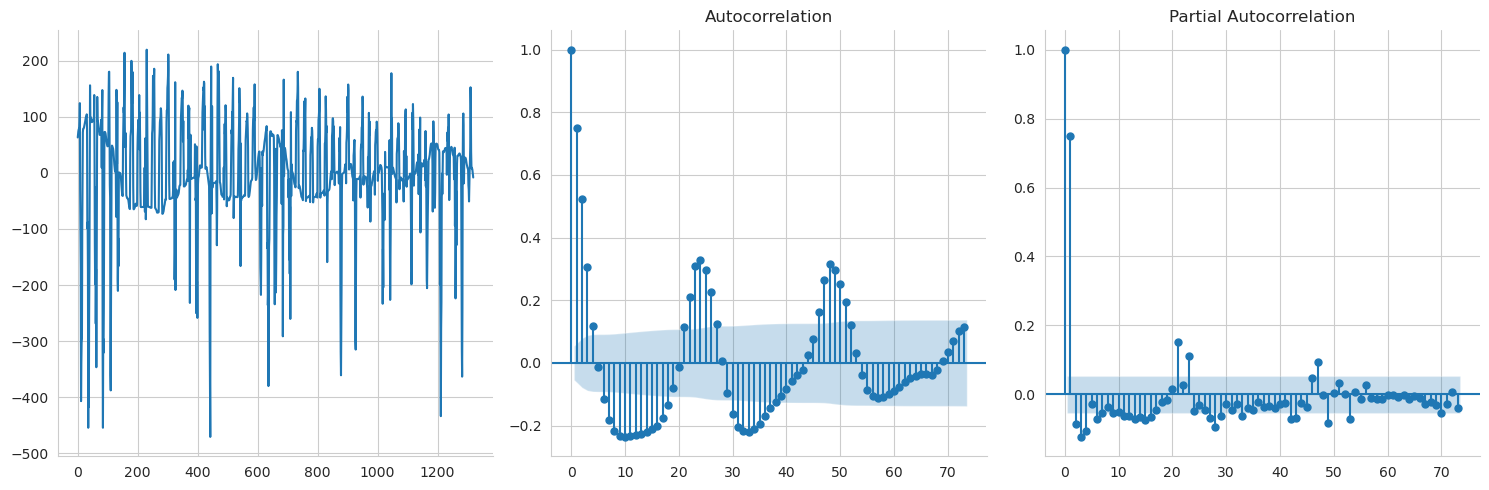

In [71]:
plots(additive_decomposed_radiation, lags=73)
# plots(hourly_radiation_df.Radiation, lags=50)

############################################################ ARMA Model ############################################################ 




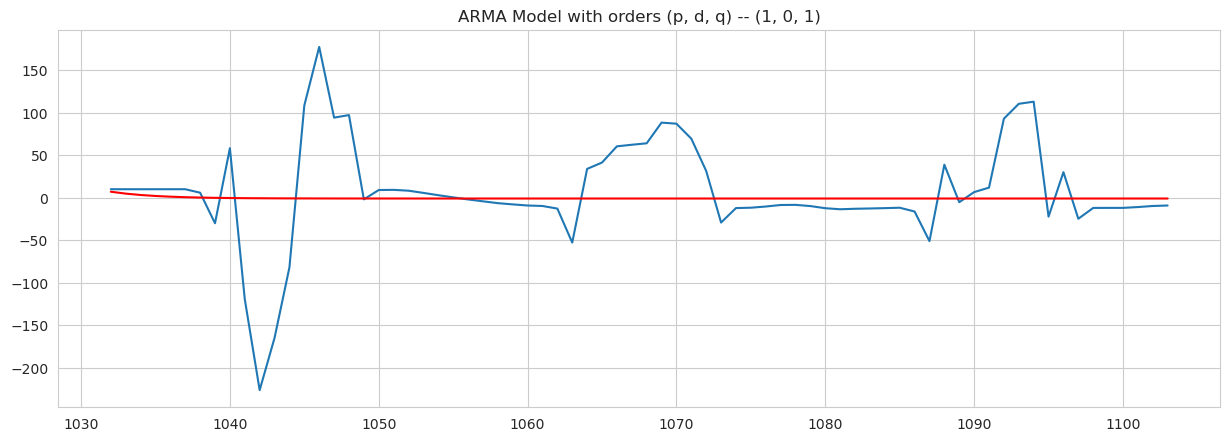



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 2.550839828559634,
 '2. Mean Percentage Error (MPE)': -2.3273789360253394,
 '3. Root Mean Squared Error (RMSE)': 66.82892552391905,
 '4. Mean Error (ME)': 12.093980979579065,
 '5. Mean Absolute Error (MAE)': 38.66295148186248,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9761492344039281}


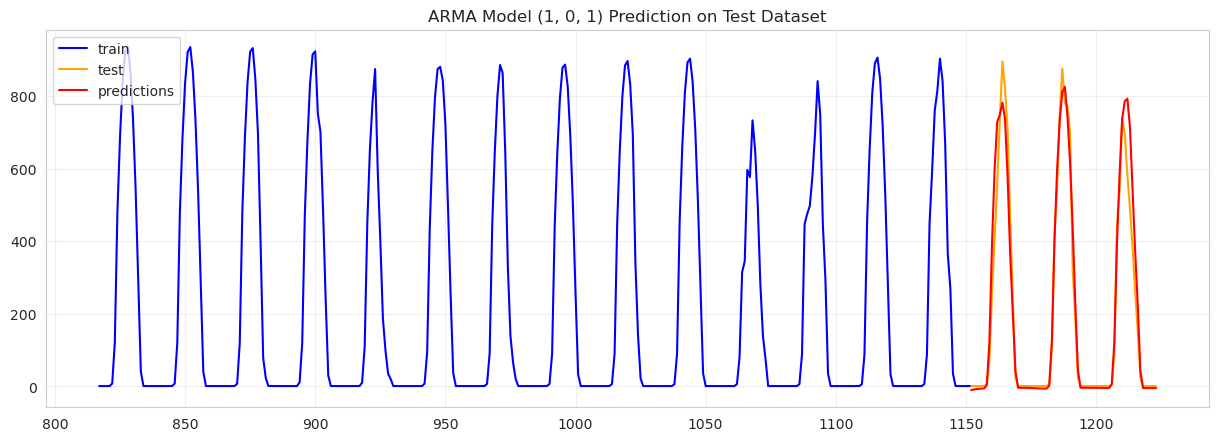

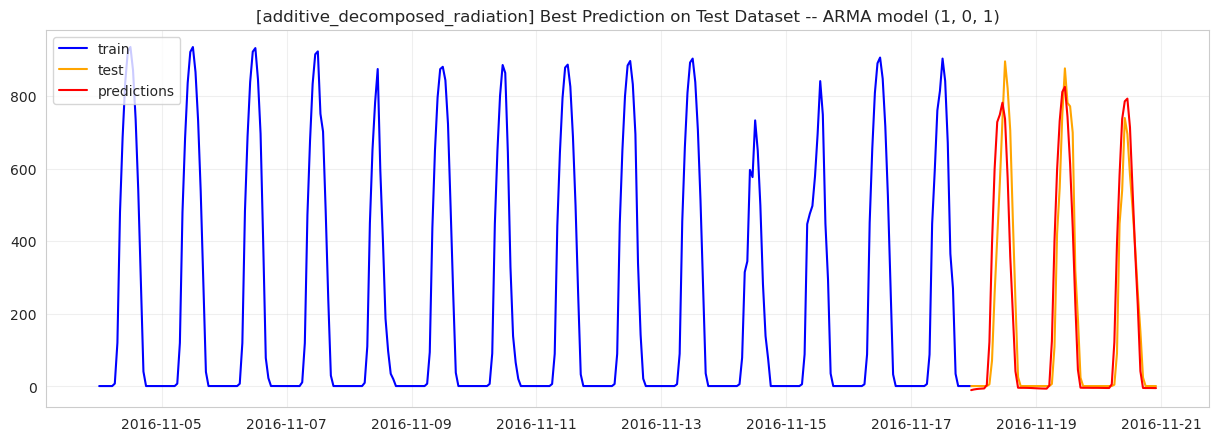

############################################################ ARMA Model ############################################################ 




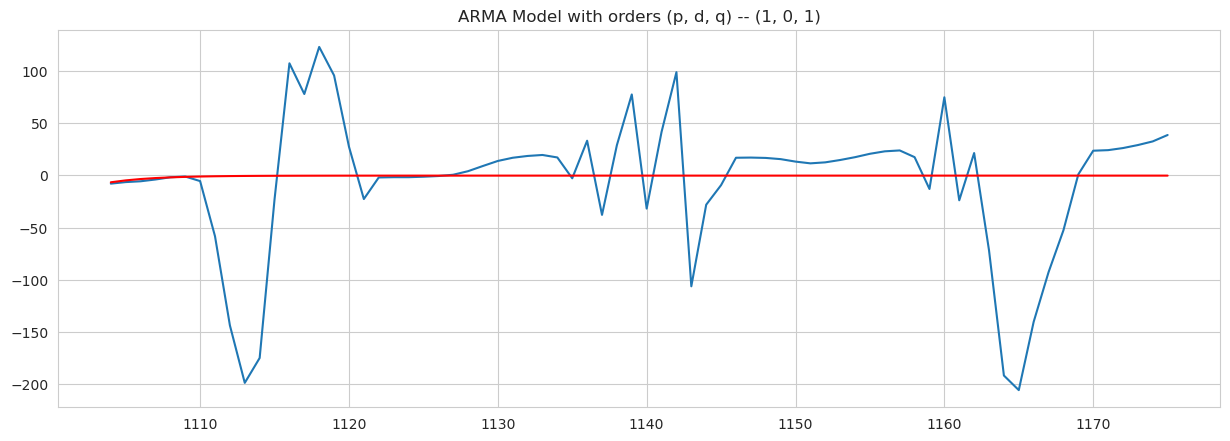



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 3.0658008491464637,
 '2. Mean Percentage Error (MPE)': -1.5004793228771582,
 '3. Root Mean Squared Error (RMSE)': 97.00288771478778,
 '4. Mean Error (ME)': 34.084785479718654,
 '5. Mean Absolute Error (MAE)': 47.59642353031203,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.955534660695771}


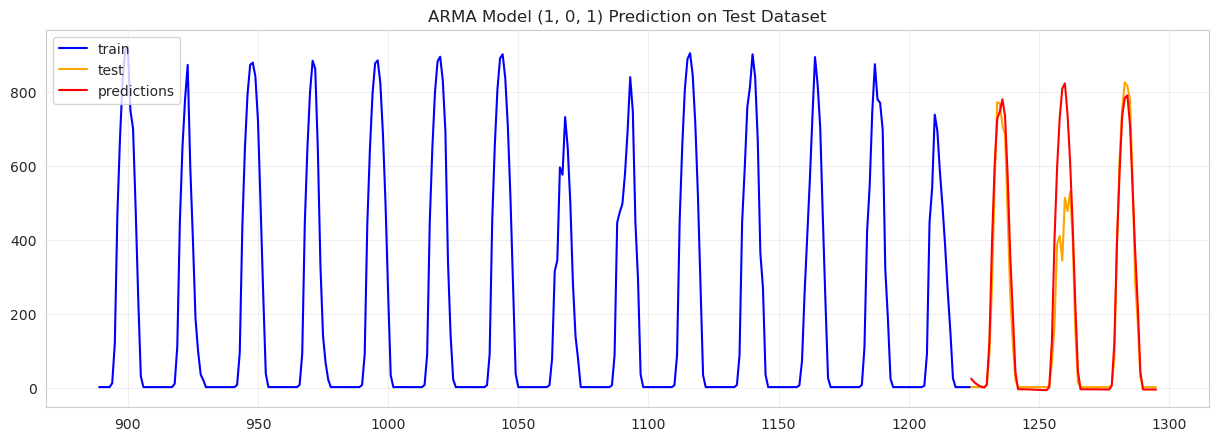

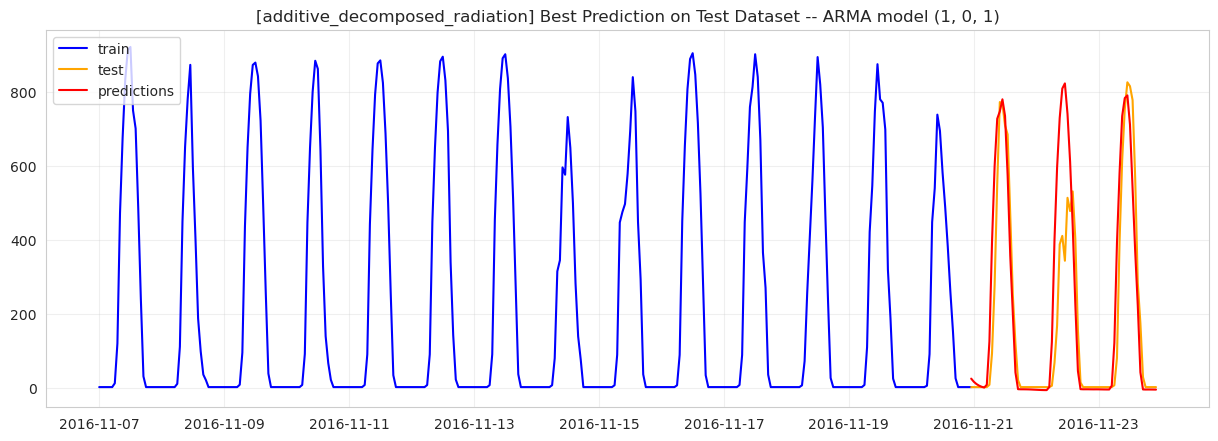

############################################################ ARMA Model ############################################################ 




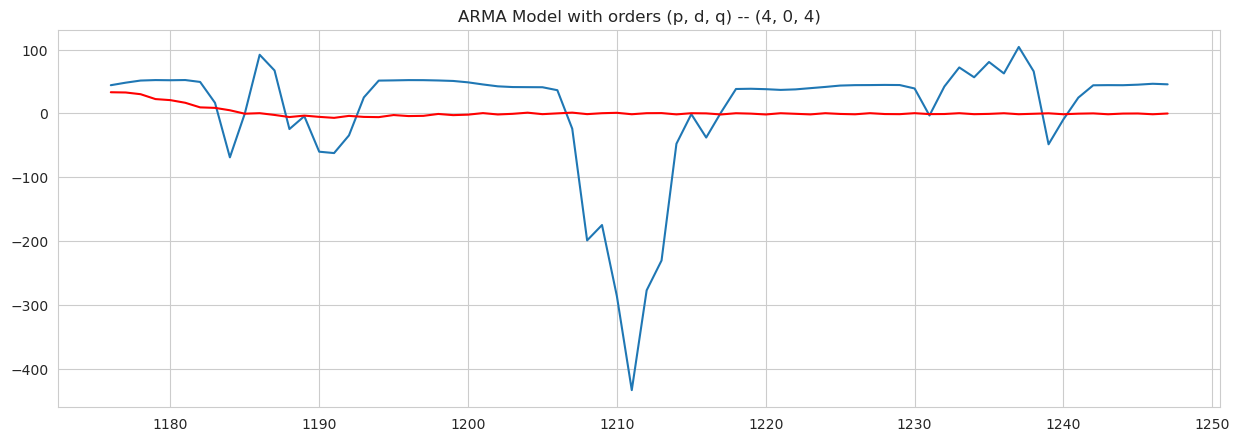



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (4, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 4.105581326065064,
 '2. Mean Percentage Error (MPE)': -3.5438724784712896,
 '3. Root Mean Squared Error (RMSE)': 89.17955912855949,
 '4. Mean Error (ME)': 16.594993943360713,
 '5. Mean Absolute Error (MAE)': 45.676358876089836,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9569952013792976}


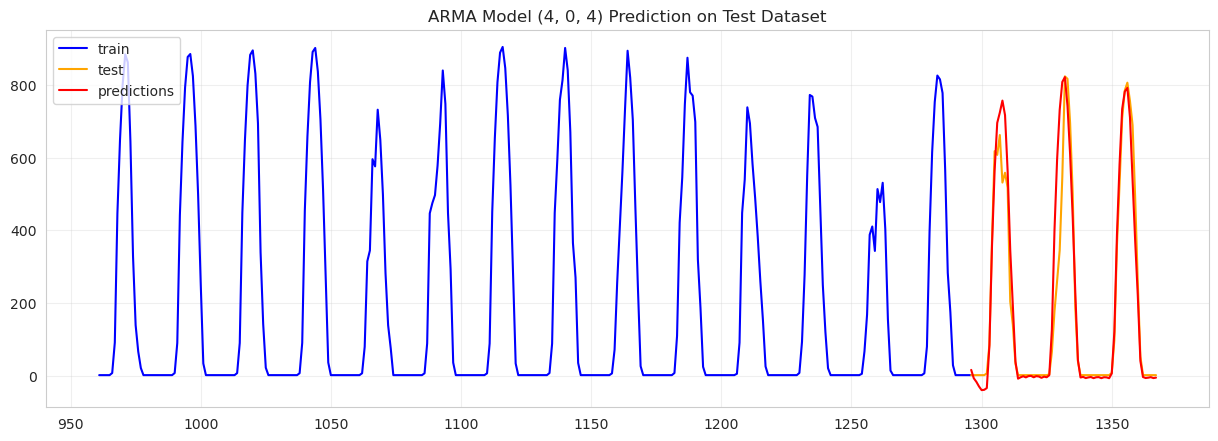

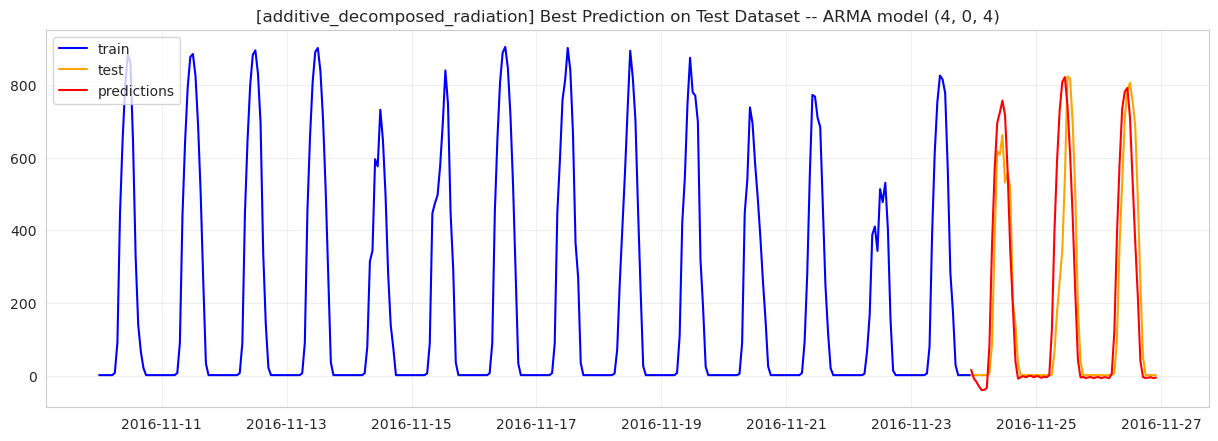

Iteration         Stationary_Series_Name  Model_Name Model_Orders  \
0         1  additive_decomposed_radiation  ARMA model    (1, 0, 1)   
1         2  additive_decomposed_radiation  ARMA model    (1, 0, 1)   
2         3  additive_decomposed_radiation  ARMA model    (4, 0, 4)   

   Mean Absolute Percentage Error (MAPE)  Mean Percentage Error (MPE)  \
0                               2.550840                    -2.327379   
1                               3.065801                    -1.500479   
2                               4.105581                    -3.543872   

   Root Mean Squared Error (RMSE)  
0                       66.828926  
1                       97.002888  
2                       89.179559

In [76]:
additive_decomposed_radiation_results_df = test_ARIMA_models(hourly_radiation_reset_df, additive_decomposed_radiation,
                                                             hourly_radiation_reset_df.Radiation,
                                                             stationary_series_name='additive_decomposed_radiation',
                                                             show_plots=True, debug_mode=False)
additive_decomposed_radiation_results_df
# additive_decomposed_radiation_results_df = test_ARIMA_models(hourly_radiation_reset_df,
#                                                               hourly_radiation_reset_df['Radiation'], hourly_radiation_reset_df['Radiation'],
#                                                               'simple_radiation',
#                                                               show_plots=True, debug_mode=True)

### Test multiplicative_decomposed_radiation stationary series

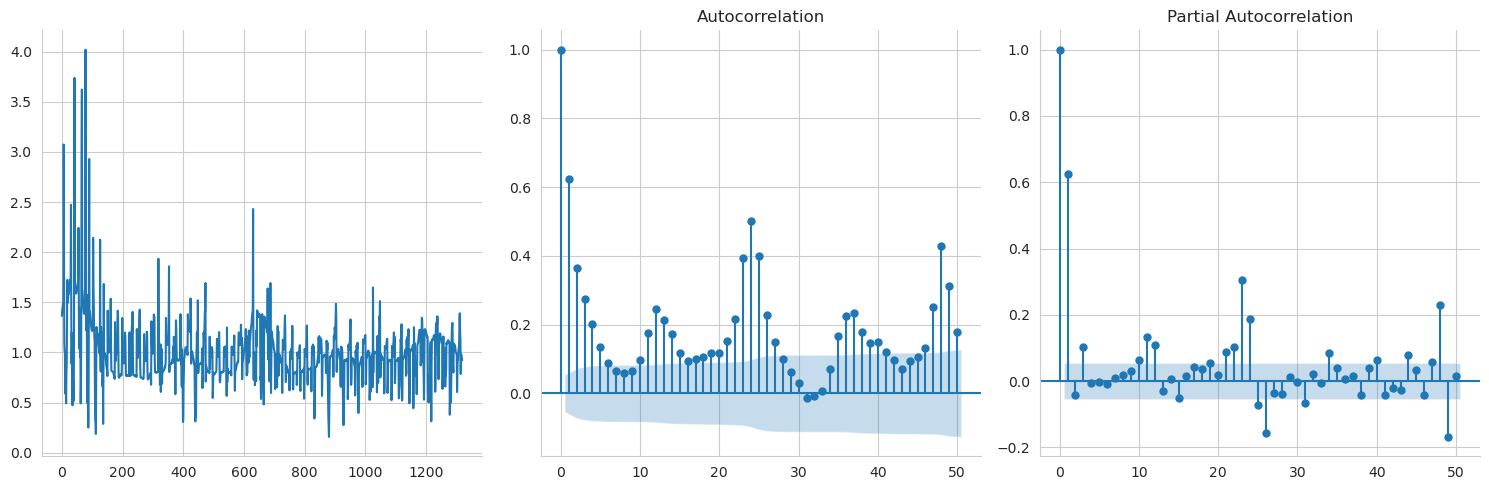

In [87]:
plots(multiplicative_decomposed_radiation, lags=50)

############################################################ ARMA Model ############################################################ 




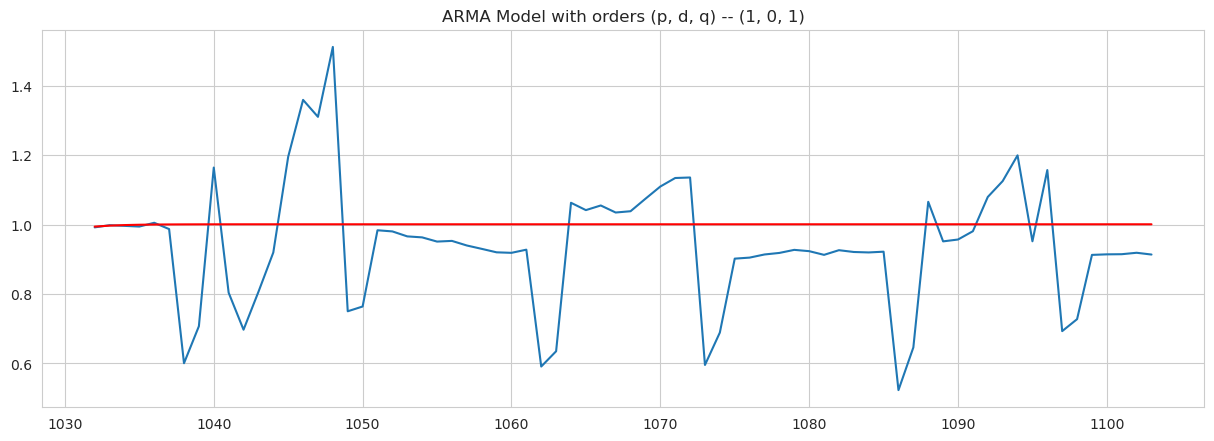



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.1948433882168314,
 '2. Mean Percentage Error (MPE)': 0.15516170846200397,
 '3. Root Mean Squared Error (RMSE)': 65.390591685978,
 '4. Mean Error (ME)': 12.03856995403193,
 '5. Mean Absolute Error (MAE)': 35.819929282681784,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9760456209561156}


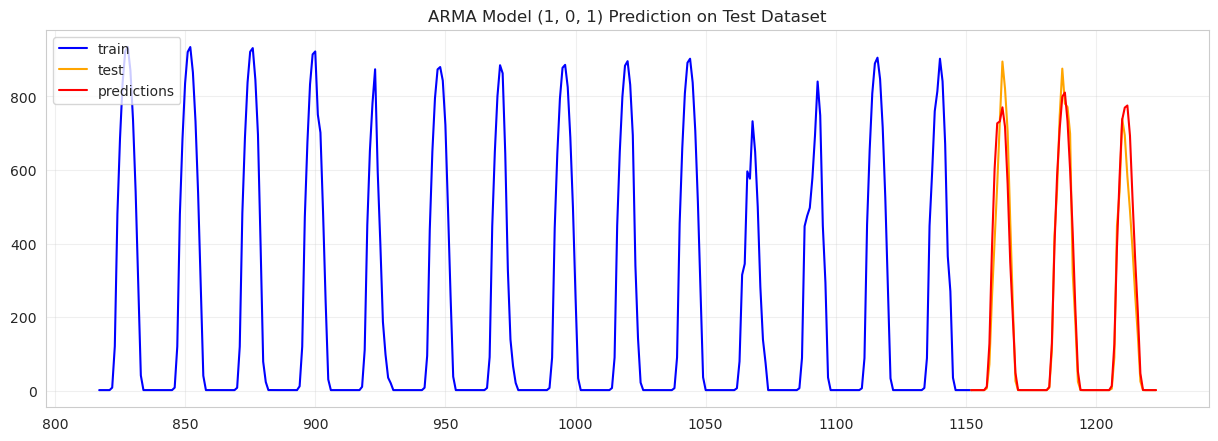

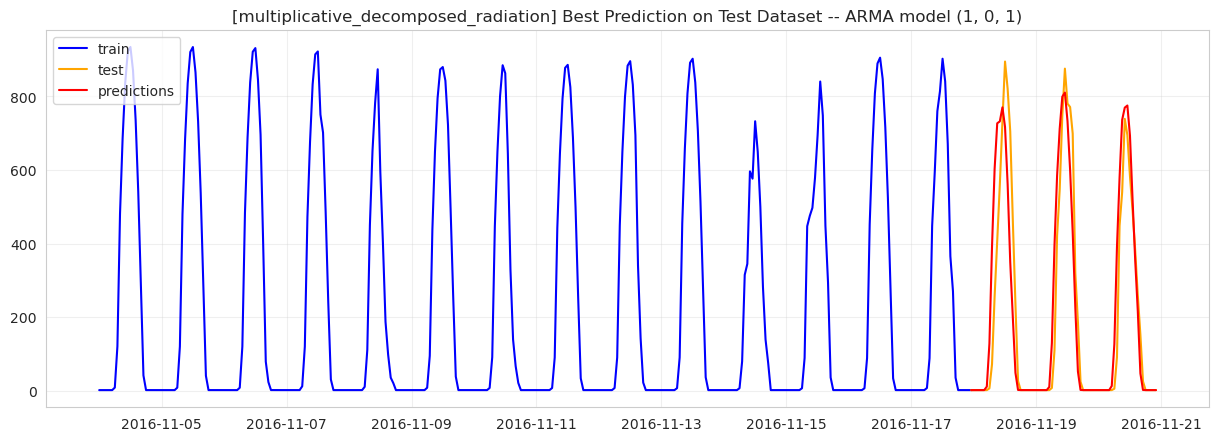

############################################################ ARMA Model ############################################################ 




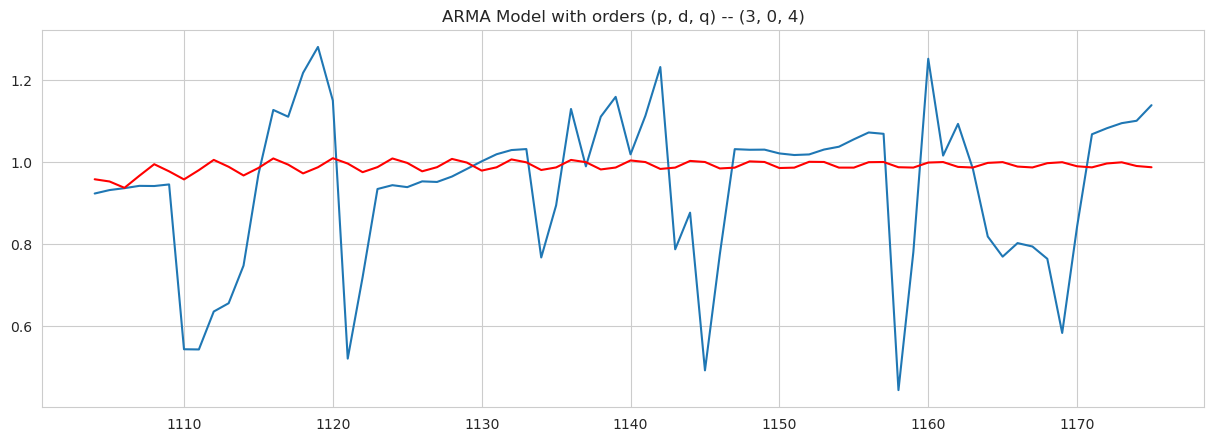



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (3, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 0.2724657270583284,
 '2. Mean Percentage Error (MPE)': 0.25662775992247155,
 '3. Root Mean Squared Error (RMSE)': 92.46457412482017,
 '4. Mean Error (ME)': 32.15717991461665,
 '5. Mean Absolute Error (MAE)': 43.536056223971144,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9558775145537978}


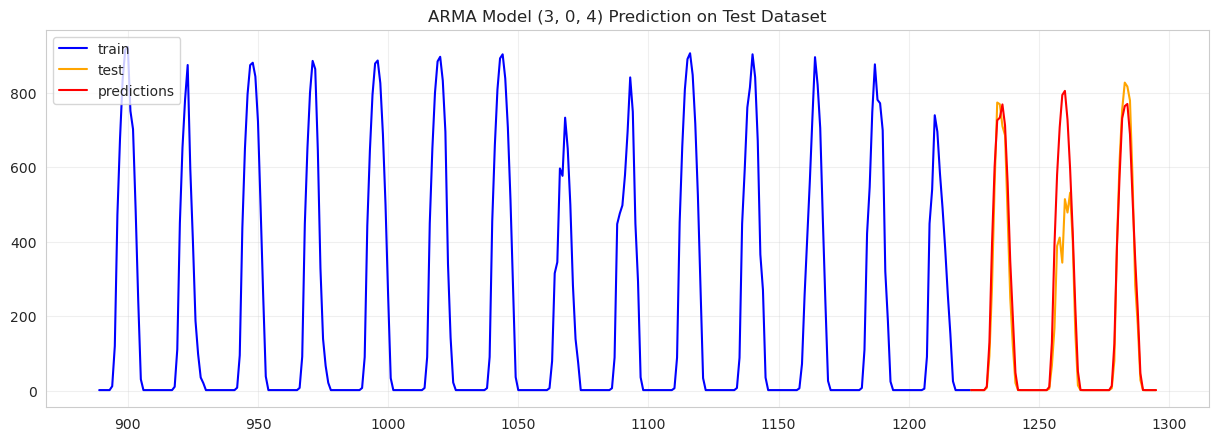

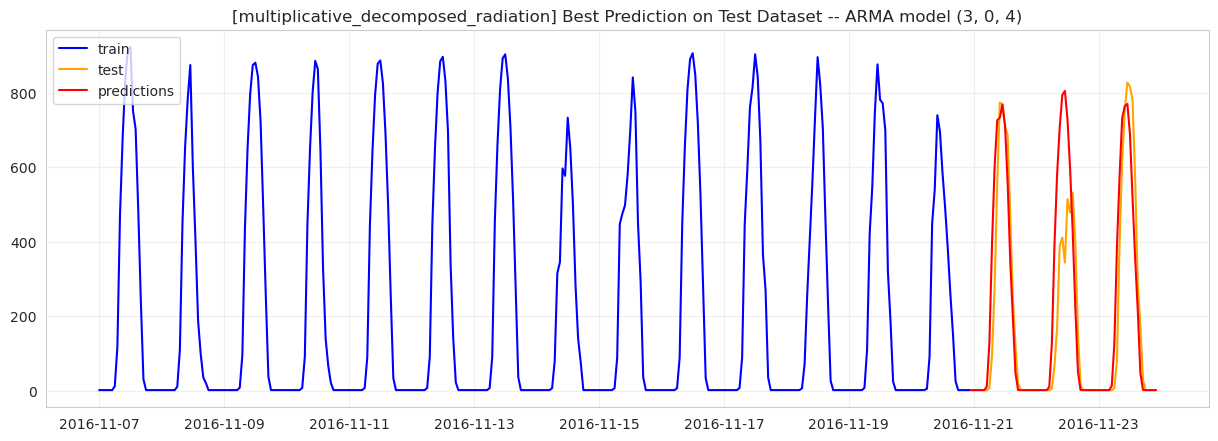

############################################################ ARMA Model ############################################################ 




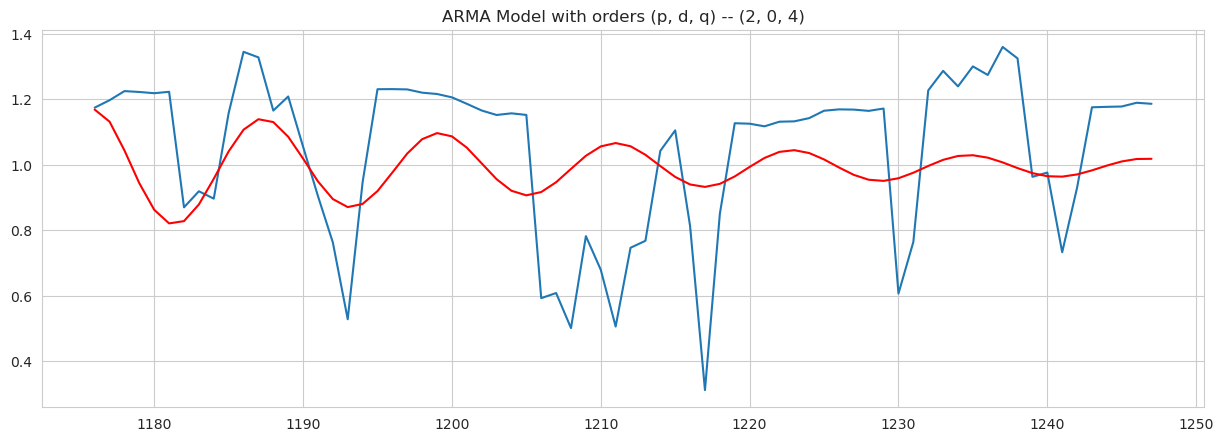



 ==================== Forecast Accuracy on Test Set [ARMA Model] ====================
Order (p, d, q) --  (2, 0, 4)
{'1. Mean Absolute Percentage Error (MAPE)': 0.280240318229319,
 '2. Mean Percentage Error (MPE)': 0.2561828365528085,
 '3. Root Mean Squared Error (RMSE)': 100.02256244501142,
 '4. Mean Error (ME)': 35.4634170947085,
 '5. Mean Absolute Error (MAE)': 48.13898393280469,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.9563544259563552}


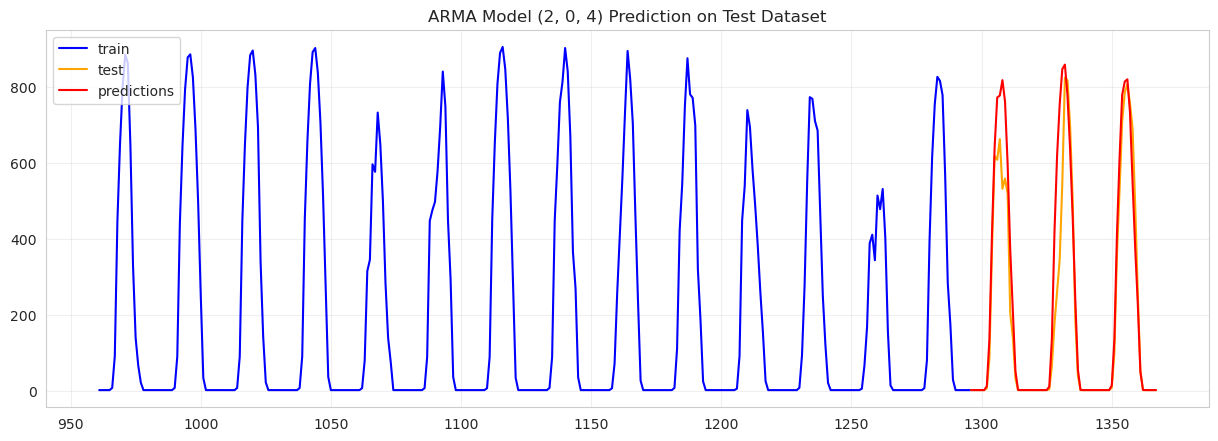

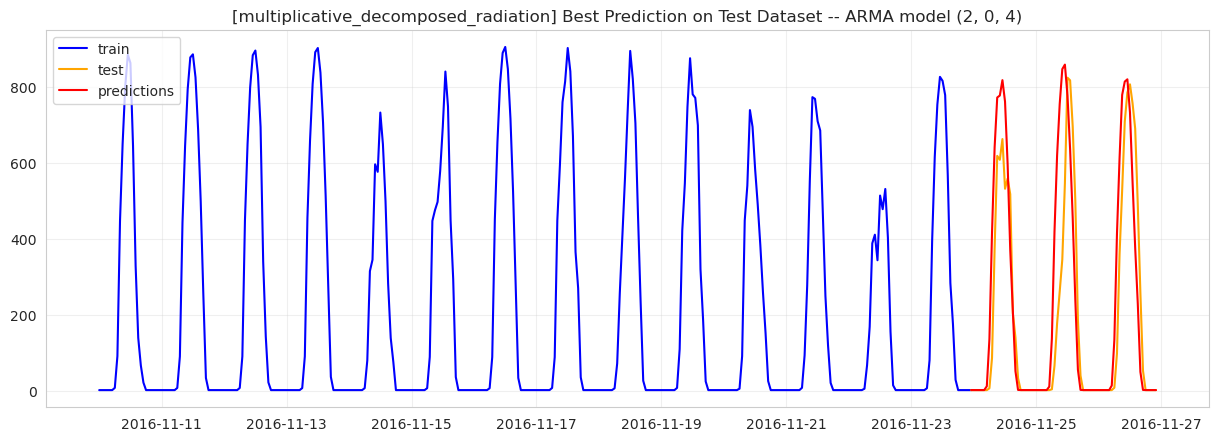

In [78]:
multiplicative_decomposed_radiation_results_df = test_ARIMA_models(hourly_radiation_reset_df, multiplicative_decomposed_radiation,
                                                                   hourly_radiation_reset_df.Log_Radiation, 'multiplicative_decomposed_radiation',
                                                                   show_plots=True, debug_mode=False)

### Test additive_diff_production_1 stationary series

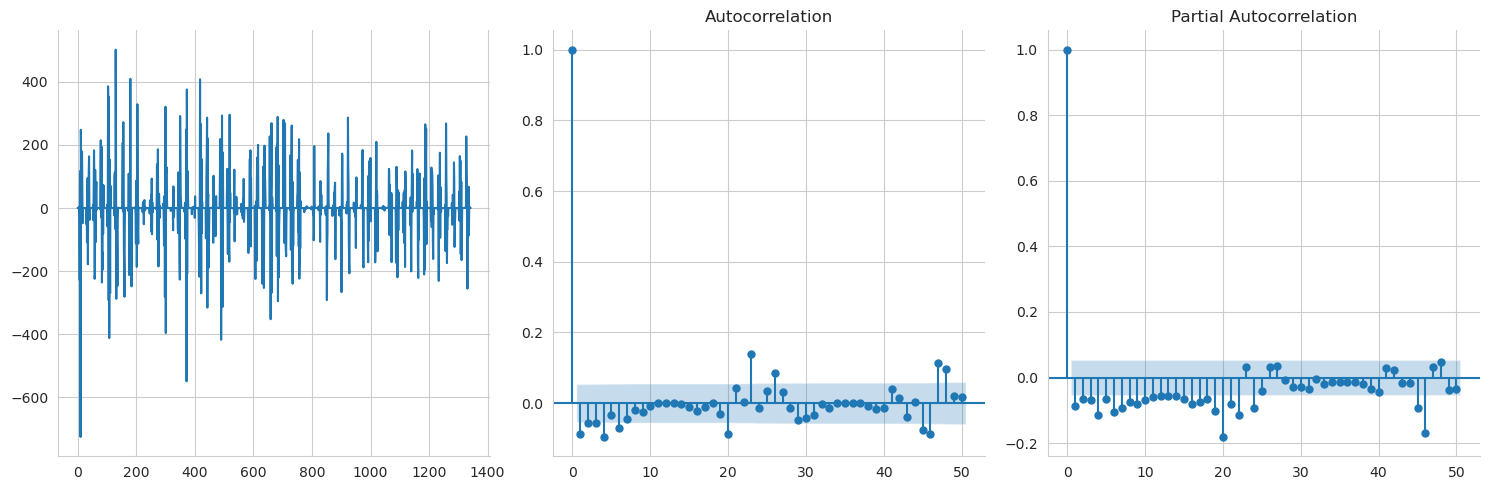

In [110]:
plots(additive_diff_production_1, lags=50)

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 1637479367.7512388,
 '2. Mean Percentage Error (MPE)': -1637479367.7512388,
 '3. Root Mean Squared Error (RMSE)': 65.37758656320139,
 '4. Mean Error (ME)': 0.0003559471529360141,
 '5. Mean Absolute Error (MAE)': 37.96396912672838,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.4096578699382617e-05}


 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 1637471048.9273431,
 '2. Mean Percentage Error (MPE)': -1637471048.9273431,
 '3. Root Mean Squared Error (RMSE)': 65.37758656136863,
 '4. Mean Error (ME)': 0.00034408500116948443,
 '5. Mean Absolute Error (MAE)': 37.96395811874449,
 '6. Correlation b

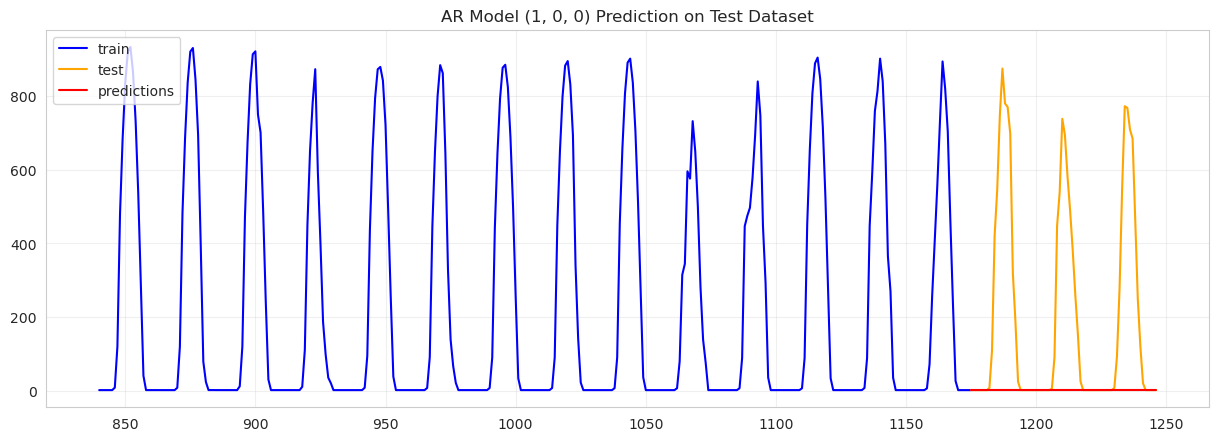










############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 1637432953.9134786,
 '2. Mean Percentage Error (MPE)': -1637432953.9134786,
 '3. Root Mean Squared Error (RMSE)': 65.3775865631537,
 '4. Mean Error (ME)': 0.0003501366105748755,
 '5. Mean Absolute Error (MAE)': 37.96397092080286,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.1219395448442186e-05}


 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 1641757652.1312373,
 '2. Mean Percentage Error (MPE)': -1641757652.1312373,
 '3. Root Mean Squared Error (RMSE)': 65.3775865597703,
 '4. Mean Error (ME)': 0.0003504170004554731,
 '5. Mean Absolute Error (MAE)': 37.96394968275908,
 '6. Correla

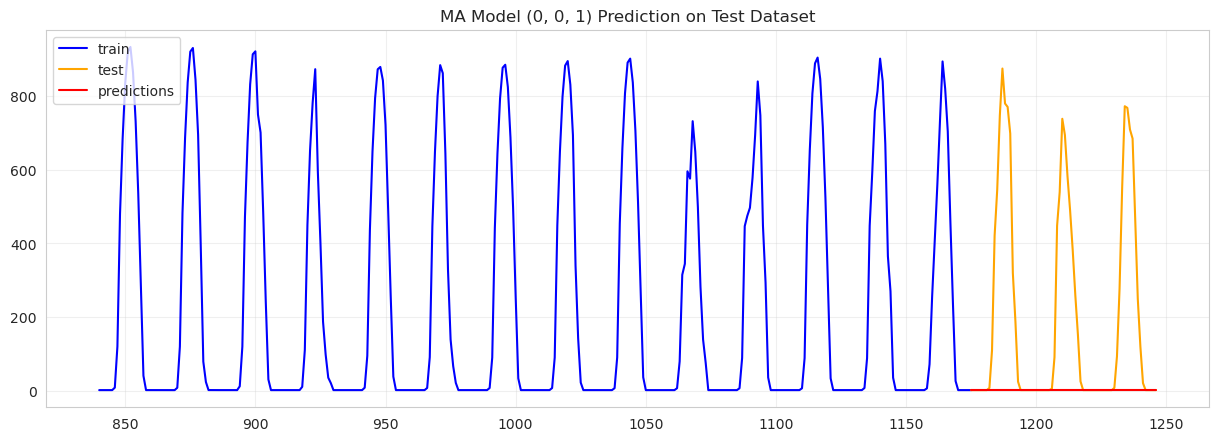










############################################################ ARMA Model ############################################################ 




 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 1943165362426.8987,
 '2. Mean Percentage Error (MPE)': 1943165362401.3362,
 '3. Root Mean Squared Error (RMSE)': 65.38948318780295,
 '4. Mean Error (ME)': -0.17095081221606911,
 '5. Mean Absolute Error (MAE)': 38.11005630147024,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.023758762098835907}


 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 1872800312948.4055,
 '2. Mean Percentage Error (MPE)': 1872800312922.7375,
 '3. Root Mean Squared Error (RMSE)': 65.38916845114728,
 '4. Mean Error (ME)': -0.17045278564163702,
 '5. Mean Absolute Error (MAE)': 38.11046070603872,
 '6. Corre

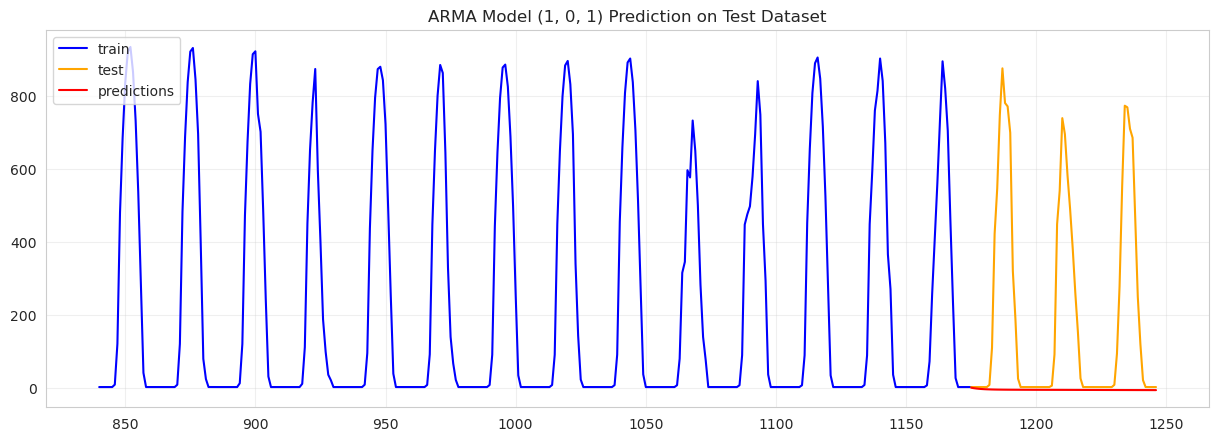










############################################################ ARIMA Model ############################################################ 




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4925575190804723,
 '2. Mean Percentage Error (MPE)': -0.48661709084363103,
 '3. Root Mean Squared Error (RMSE)': 389.27876353958857,
 '4. Mean Error (ME)': -227.99109953703703,
 '5. Mean Absolute Error (MAE)': 227.998275462963,
 '6. Correlation between the Actual and the Forecast (CORR)': nan}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.6159191366926637,
 '2. Mean Percentage Error (MPE)': -0.6159191366926637,
 '3. Root Mean Squared Error (RMSE)': 389.4591743561435,
 '4. Mean Error (ME)': -228.2990017835497,
 '5. Mean Absolute Error (MAE)': 228.2990017835497,
 '6. Correlation between 

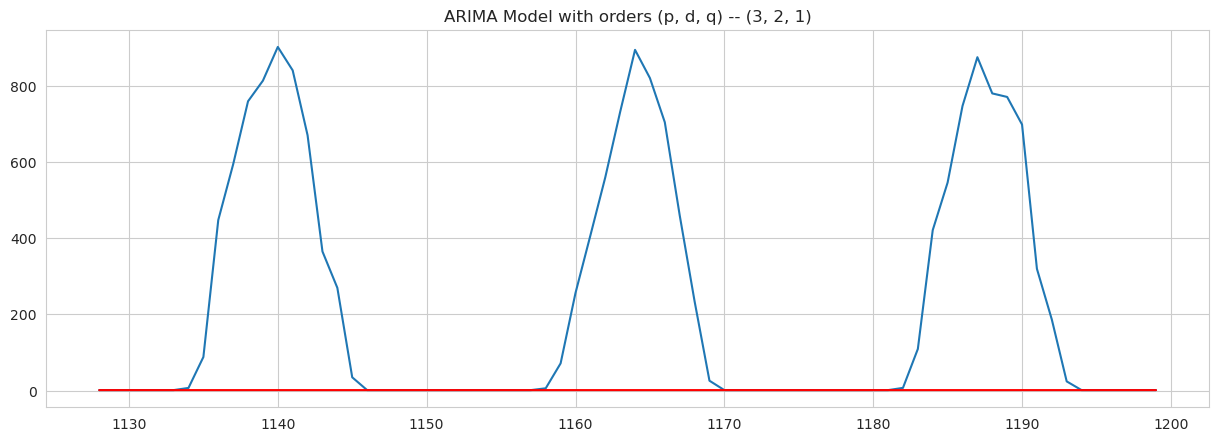



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (3, 2, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5039211907420611,
 '2. Mean Percentage Error (MPE)': -0.5034201643843541,
 '3. Root Mean Squared Error (RMSE)': 302.6915279838525,
 '4. Mean Error (ME)': -174.5728471334638,
 '5. Mean Absolute Error (MAE)': 174.57345479739254,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.059654161423870526}


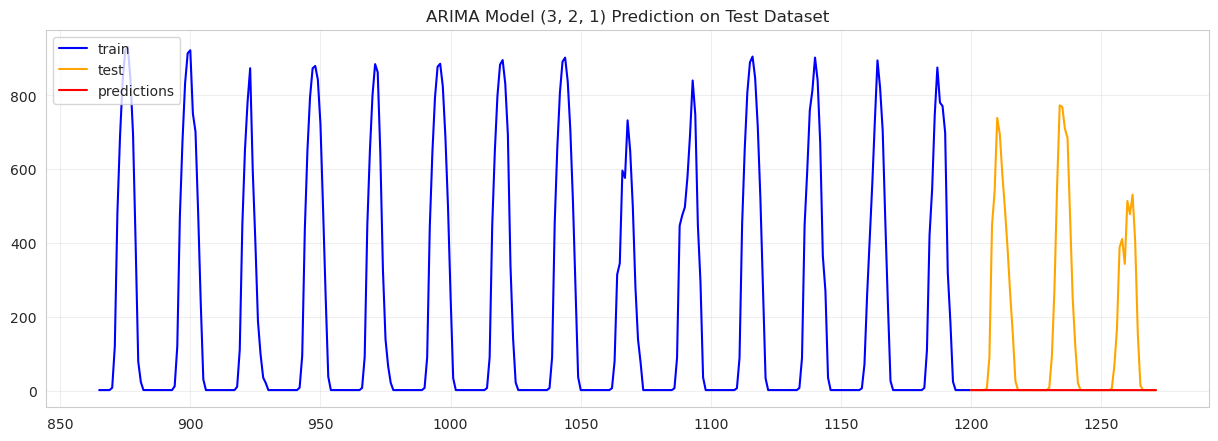

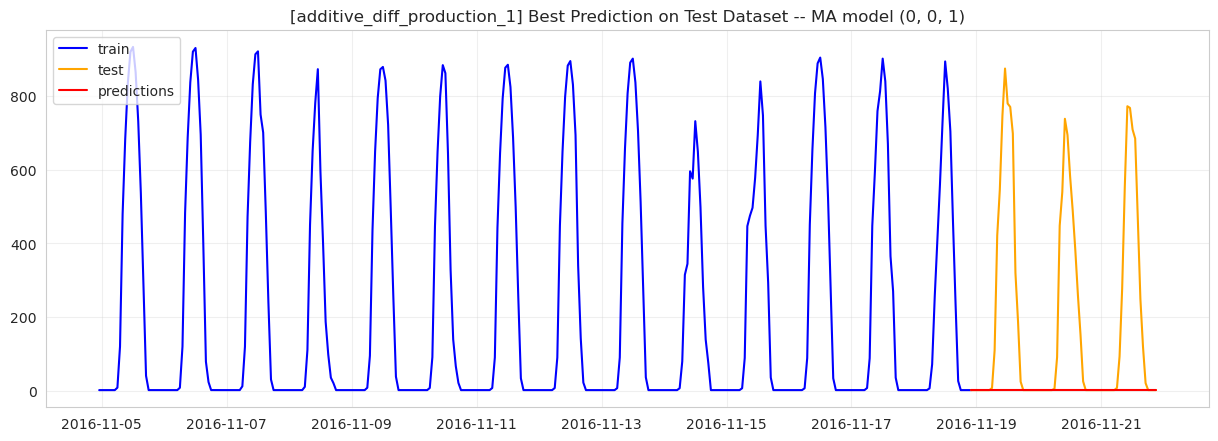

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 85.67874183307805,
 '4. Mean Error (ME)': 0.0005305412344951163,
 '5. Mean Absolute Error (MAE)': 46.36917101058131,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.7360721489893393e-05}


 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 85.67874183099663,
 '4. Mean Error (ME)': 0.0005437829723583655,
 '5. Mean Absolute Error (MAE)': 46.369159053319535,
 '6. Correlation between the Actual and the Forecast (CORR)': -3.569249447448668

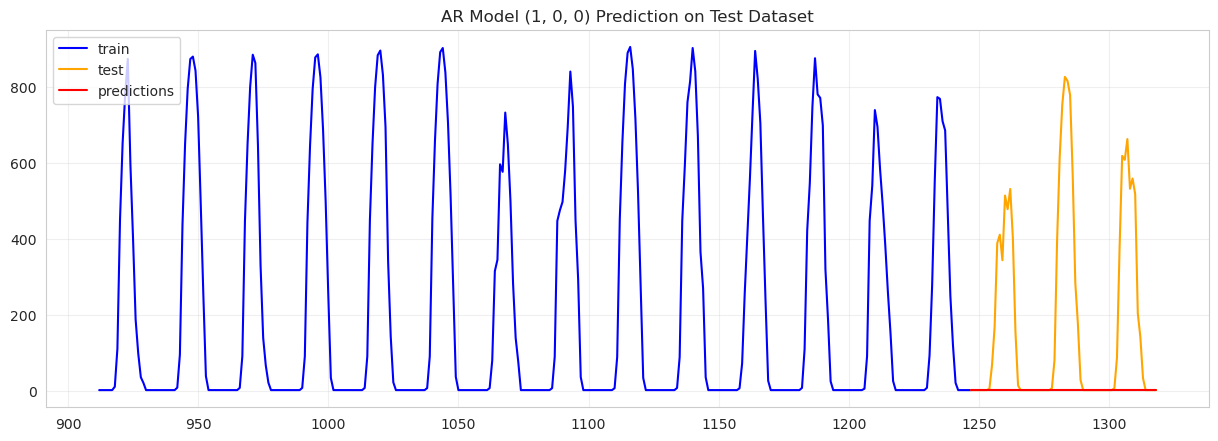










############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 85.67874183324271,
 '4. Mean Error (ME)': 0.0005355987786204411,
 '5. Mean Absolute Error (MAE)': 46.36917154958326,
 '6. Correlation between the Actual and the Forecast (CORR)': -1.566458794852578e-05}


 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': inf,
 '3. Root Mean Squared Error (RMSE)': 85.67874251784919,
 '4. Mean Error (ME)': -0.001199603708233749,
 '5. Mean Absolute Error (MAE)': 46.370530360352035,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.20095840

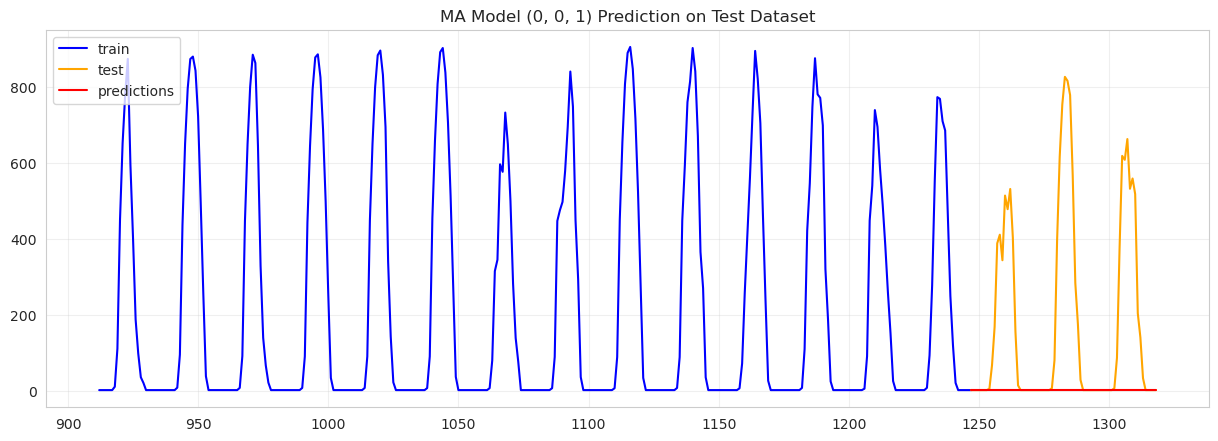










############################################################ ARMA Model ############################################################ 




 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.67639947027403,
 '4. Mean Error (ME)': -0.11611752981209615,
 '5. Mean Absolute Error (MAE)': 46.447874111793176,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.009996643462005898}


 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 85.67655222210394,
 '4. Mean Error (ME)': -0.11545882755535469,
 '5. Mean Absolute Error (MAE)': 46.448380512080476,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.009

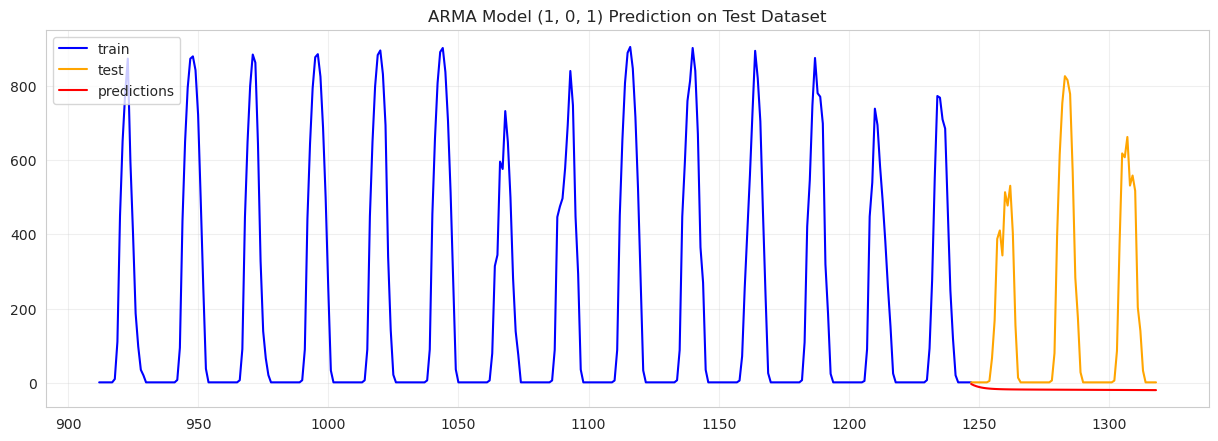










############################################################ ARIMA Model ############################################################ 




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4919679537905386,
 '2. Mean Percentage Error (MPE)': -0.4806022950928296,
 '3. Root Mean Squared Error (RMSE)': 302.66219211978733,
 '4. Mean Error (ME)': -174.51929187710437,
 '5. Mean Absolute Error (MAE)': 174.53293034511782,
 '6. Correlation between the Actual and the Forecast (CORR)': nan}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.6632703531540489,
 '2. Mean Percentage Error (MPE)': -0.6632703531540489,
 '3. Root Mean Squared Error (RMSE)': 302.90996878518627,
 '4. Mean Error (ME)': -174.9486492887939,
 '5. Mean Absolute Error (MAE)': 174.9486492887939,
 '6. Correlation betwee

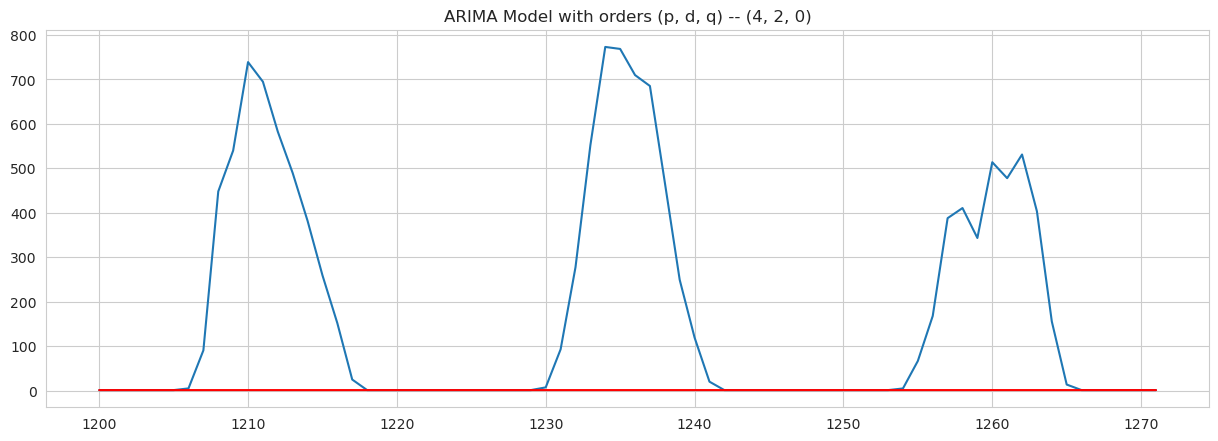



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (4, 2, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.6508956296564463,
 '2. Mean Percentage Error (MPE)': -0.6508956296564463,
 '3. Root Mean Squared Error (RMSE)': 341.14360739798167,
 '4. Mean Error (ME)': -195.98990676484945,
 '5. Mean Absolute Error (MAE)': 195.98990676484945,
 '6. Correlation between the Actual and the Forecast (CORR)': 0.0417044942916338}


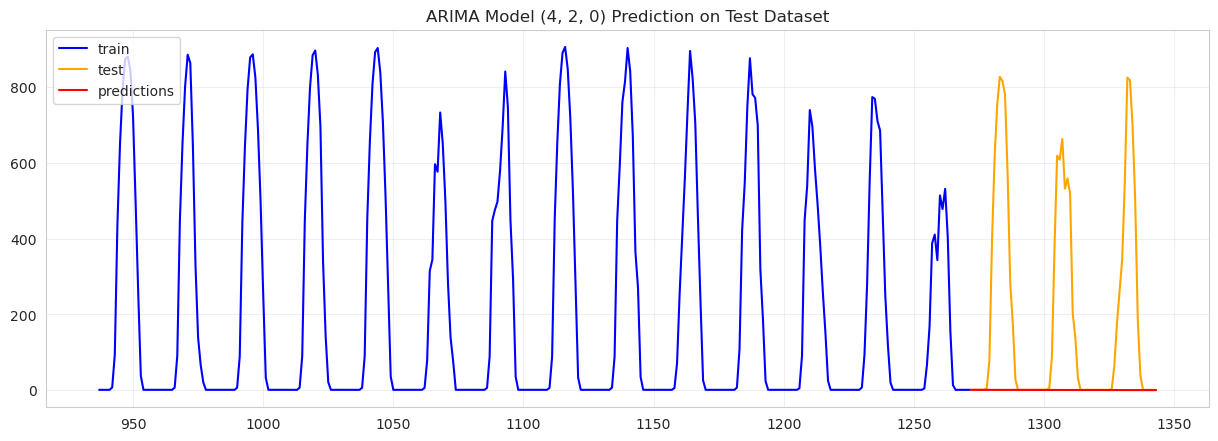

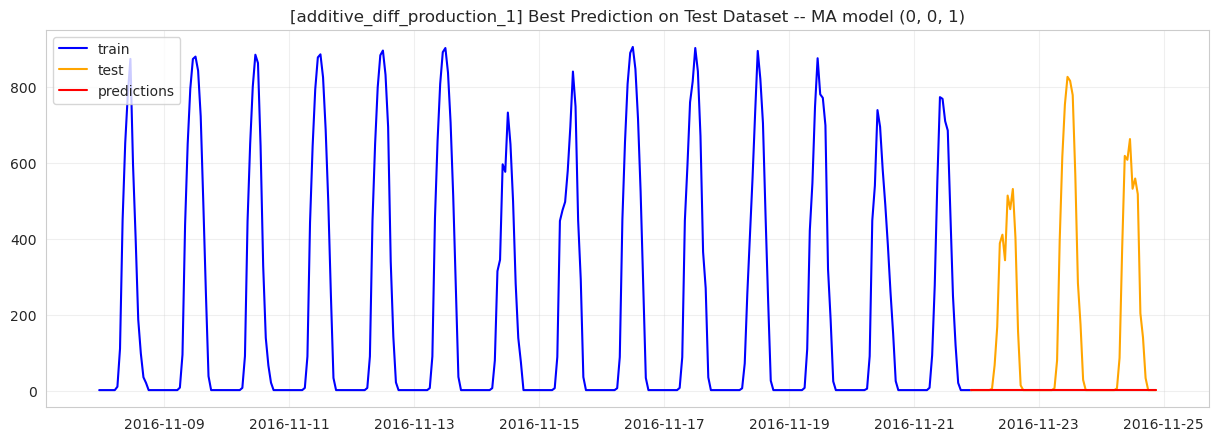

############################################################ AR Model ############################################################ 




 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (1, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.1832940267208,
 '4. Mean Error (ME)': -0.0009342538823054901,
 '5. Mean Absolute Error (MAE)': 37.1444430123653,
 '6. Correlation between the Actual and the Forecast (CORR)': 3.924056563340984e-07}


 ==================== Forecast Accuracy [AR Model] ====================
Order (p, d, q) --  (2, 0, 0)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18329402665503,
 '4. Mean Error (ME)': -0.0009277230220826974,
 '5. Mean Absolute Error (MAE)': 37.14443580104402,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.5214450534345642e

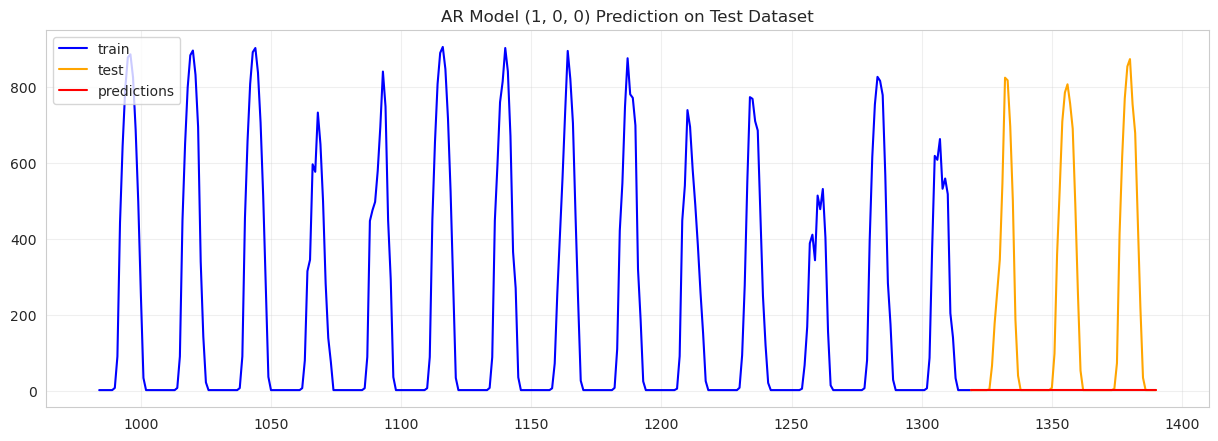










############################################################ MA Model ############################################################ 




 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18329402647812,
 '4. Mean Error (ME)': -0.0009301656319762072,
 '5. Mean Absolute Error (MAE)': 37.14443896437925,
 '6. Correlation between the Actual and the Forecast (CORR)': 1.5087820287211485e-06}


 ==================== Forecast Accuracy [MA Model] ====================
Order (p, d, q) --  (0, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.18329416297205,
 '4. Mean Error (ME)': -0.0015147586959803523,
 '5. Mean Absolute Error (MAE)': 37.14502366143601,
 '6. Correlation between the Actual and the Forecast (CORR)': -4.2620

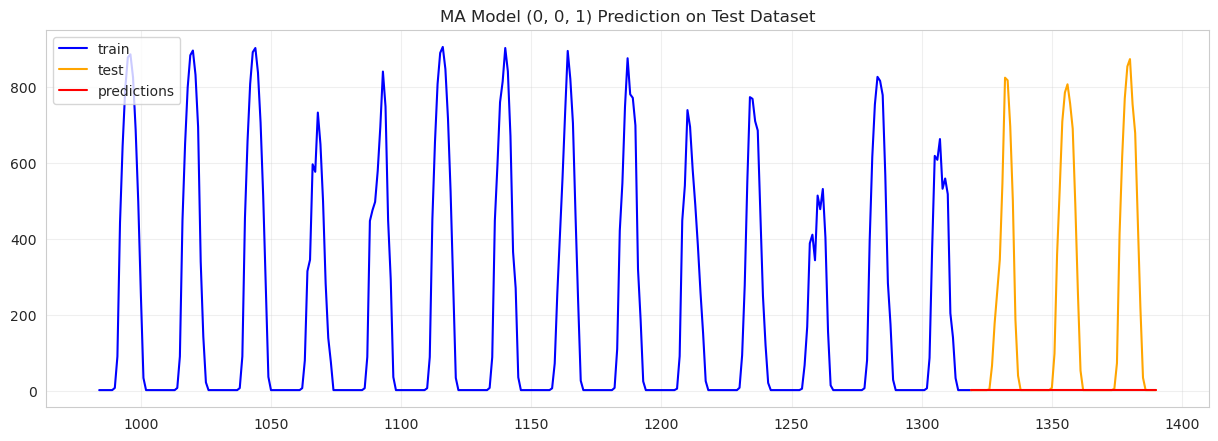










############################################################ ARMA Model ############################################################ 




 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 1)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.19423148398369,
 '4. Mean Error (ME)': -0.29147435597564925,
 '5. Mean Absolute Error (MAE)': 37.363369734554254,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.008039433003269305}


 ==================== Forecast Accuracy [ARMA Model] ====================
Order (p, d, q) --  (1, 0, 2)
{'1. Mean Absolute Percentage Error (MAPE)': inf,
 '2. Mean Percentage Error (MPE)': -inf,
 '3. Root Mean Squared Error (RMSE)': 70.19398325968541,
 '4. Mean Error (ME)': -0.2920260708603332,
 '5. Mean Absolute Error (MAE)': 37.36716960214018,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.007

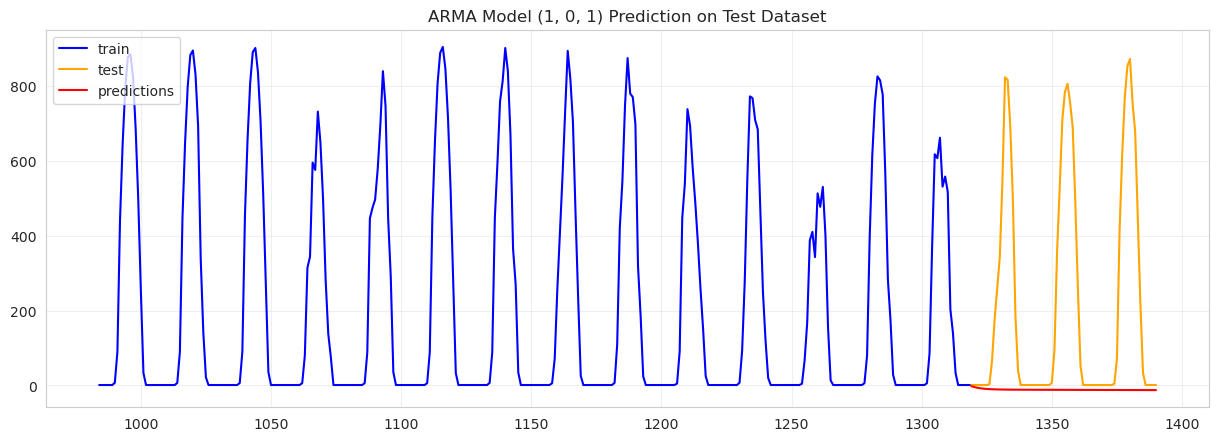










############################################################ ARIMA Model ############################################################ 




 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 0)
{'1. Mean Absolute Percentage Error (MAPE)': 0.4954861165737277,
 '2. Mean Percentage Error (MPE)': -0.4954665271676785,
 '3. Root Mean Squared Error (RMSE)': 340.9407179881479,
 '4. Mean Error (ME)': -195.62429503367002,
 '5. Mean Absolute Error (MAE)': 195.62431818181818,
 '6. Correlation between the Actual and the Forecast (CORR)': nan}


 ==================== Forecast Accuracy [ARIMA Model] ====================
Order (p, d, q) --  (0, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5587207811024022,
 '2. Mean Percentage Error (MPE)': -0.5587207811024022,
 '3. Root Mean Squared Error (RMSE)': 341.025803411685,
 '4. Mean Error (ME)': -195.77254715033916,
 '5. Mean Absolute Error (MAE)': 195.77254715033916,
 '6. Correlation between

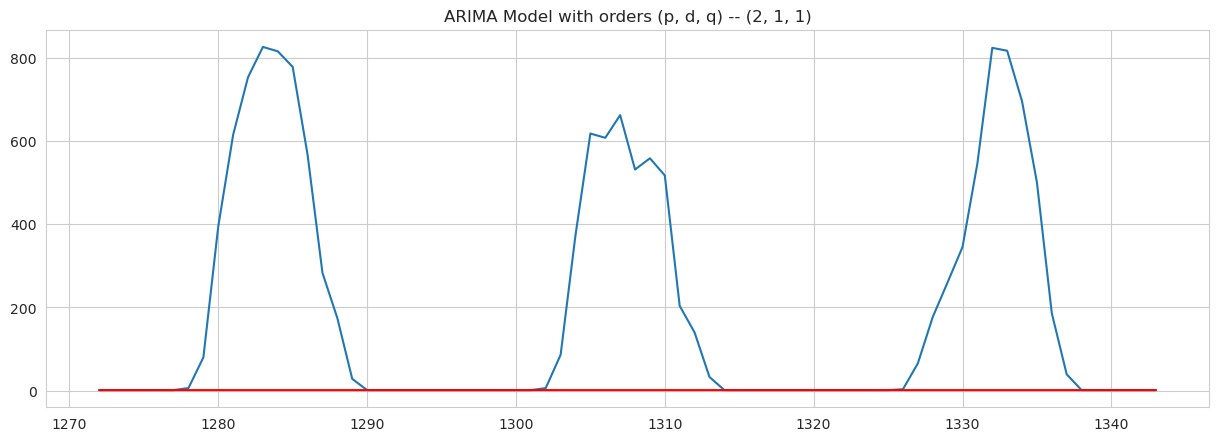



 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.502205924120071,
 '2. Mean Percentage Error (MPE)': -0.502205924120071,
 '3. Root Mean Squared Error (RMSE)': 401.5939268044351,
 '4. Mean Error (ME)': -238.92128380893206,
 '5. Mean Absolute Error (MAE)': 238.92128380893206,
 '6. Correlation between the Actual and the Forecast (CORR)': -0.18160042764925574}


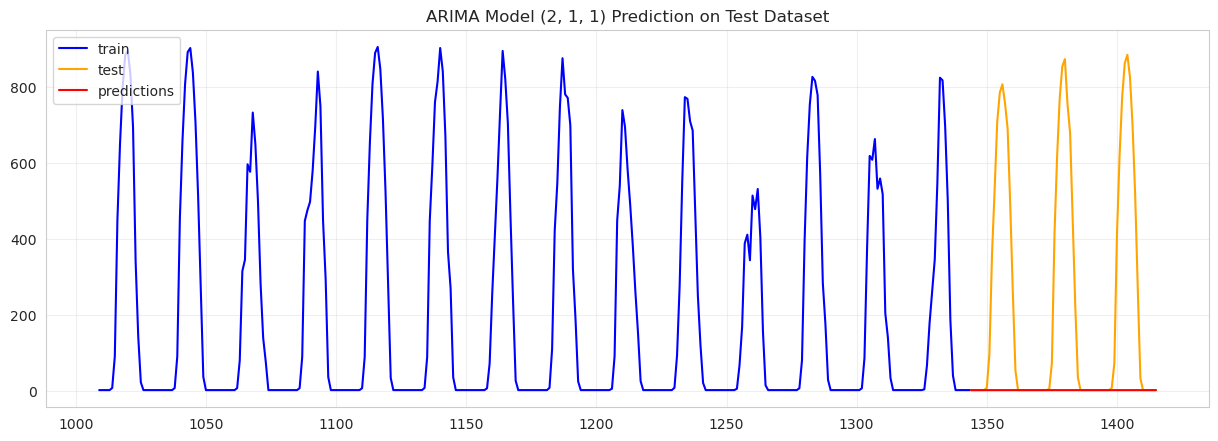

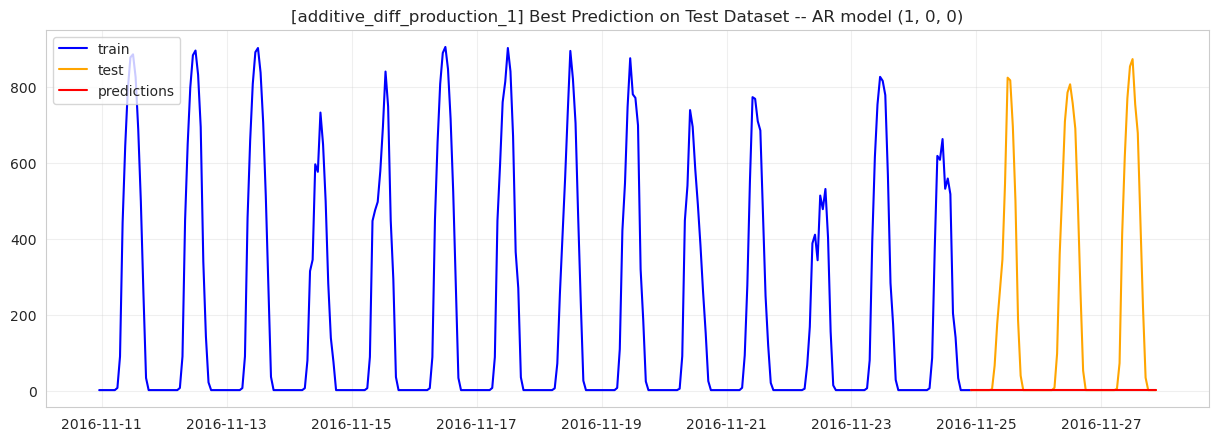

In [115]:
additive_diff_production_1_results_df = test_ARIMA_models(hourly_radiation_reset_df,additive_diff_production_1,
                                                          hourly_radiation_reset_df.Radiation, 'additive_diff_production_1',
                                                          show_plots=True, debug_mode=True)

### Test multiplicative_diff_production_1 stationary series

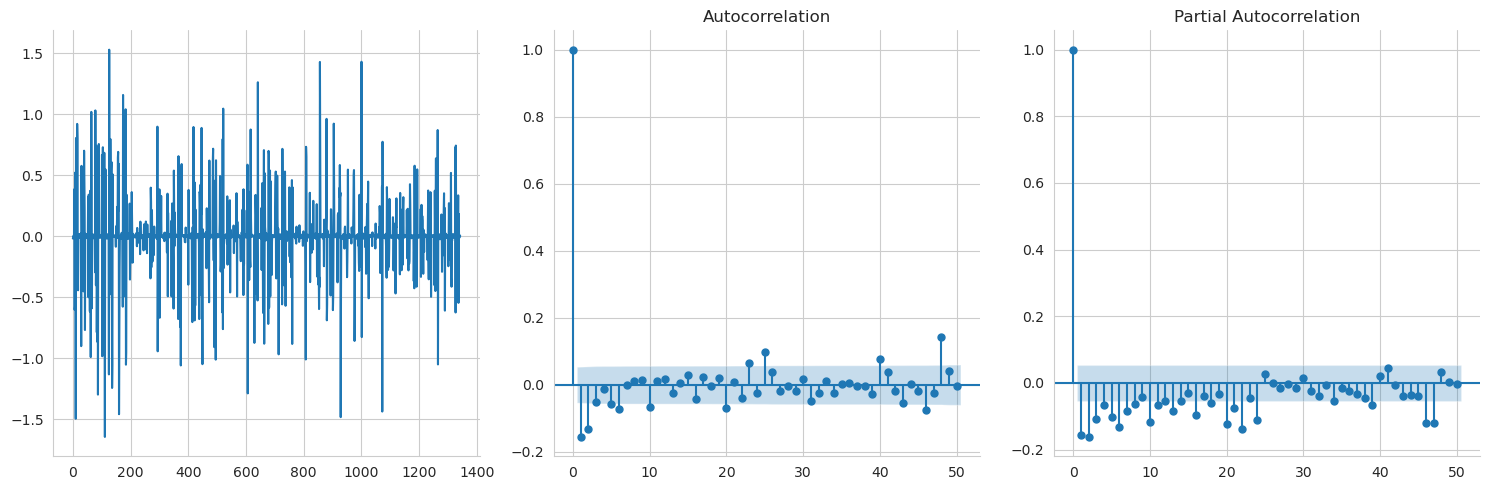

In [119]:
plots(multiplicative_diff_production_1, lags=50)

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49197065192110045,
 '2. Mean Percentage Error (MPE)': -0.4806118635093448,
 '3. Root Mean Squared Error (RMSE)': 302.66217237031213,
 '4. Mean Error (ME)': -174.5193066924922,
 '5. Mean Absolute Error (MAE)': 174.5329387458211,
 '6. Correlation between the Actual and the Fo

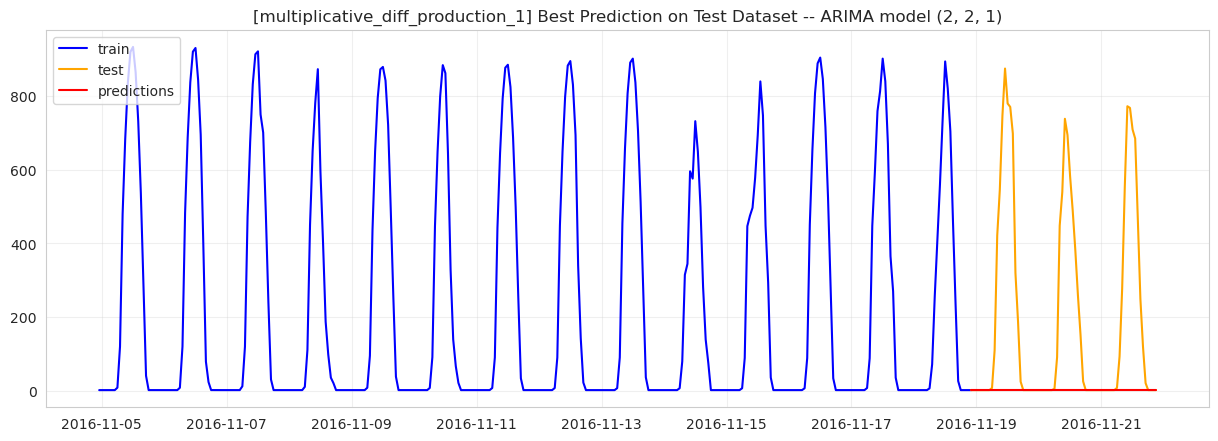

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (1, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5022787768704121,
 '2. Mean Percentage Error (MPE)': -0.5022787768704121,
 '3. Root Mean Squared Error (RMSE)': 340.9500491196197,
 '4. Mean Error (ME)': -195.64040726817058,
 '5. Mean Absolute Error (MAE)': 195.64040726817058,
 '6. Correlation between the Actual and the Fo

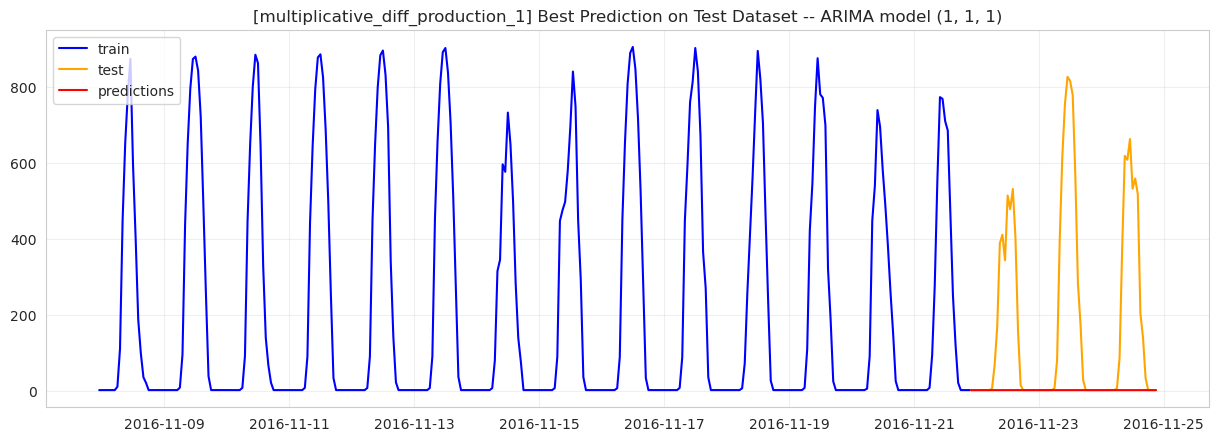

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.500407793570513,
 '2. Mean Percentage Error (MPE)': -0.4769821298200876,
 '3. Root Mean Squared Error (RMSE)': 401.55752704890097,
 '4. Mean Error (ME)': -238.86097478565418,
 '5. Mean Absolute Error (MAE)': 238.88911972842138,
 '6. Correlation between the Actual and the Fo

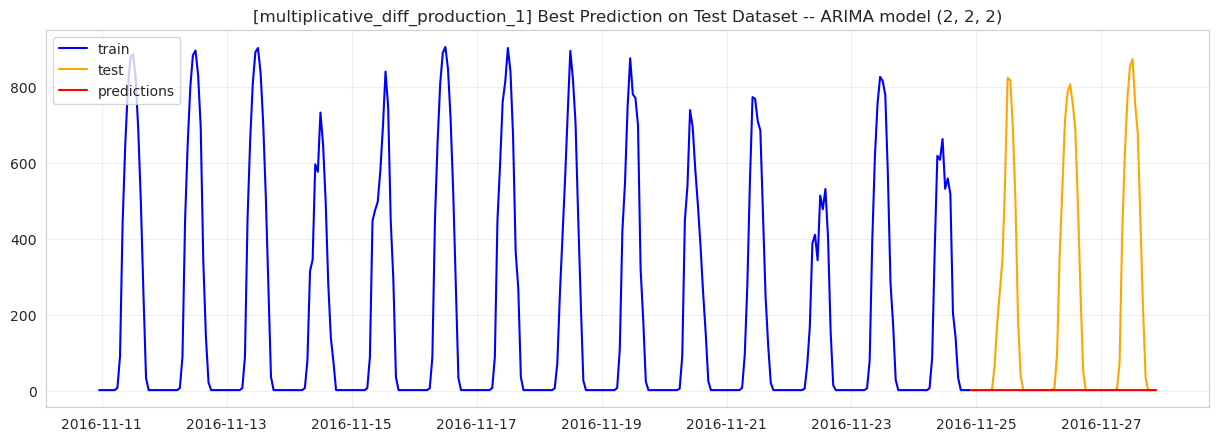

In [120]:
multiplicative_diff_production_1_results_df = test_ARIMA_models(hourly_radiation_reset_df, multiplicative_diff_production_1,
                                                                hourly_radiation_reset_df.Log_Radiation, 'multiplicative_diff_production_1',
                                                                show_plots=False, debug_mode=False)

### Test additive_diff_production_12 stationary series

In [121]:
# plots(additive_diff_production_12, lags=50)

In [122]:
# additive_diff_production_12_results_df = test_ARIMA_models(hourly_radiation_reset_df, additive_diff_production_12,
#                                                           hourly_radiation_reset_df.Radiation, 'additive_diff_production_12',
#                                                           show_plots=False, debug_mode=False)

### Test multiplicative_diff_production_12 stationary series

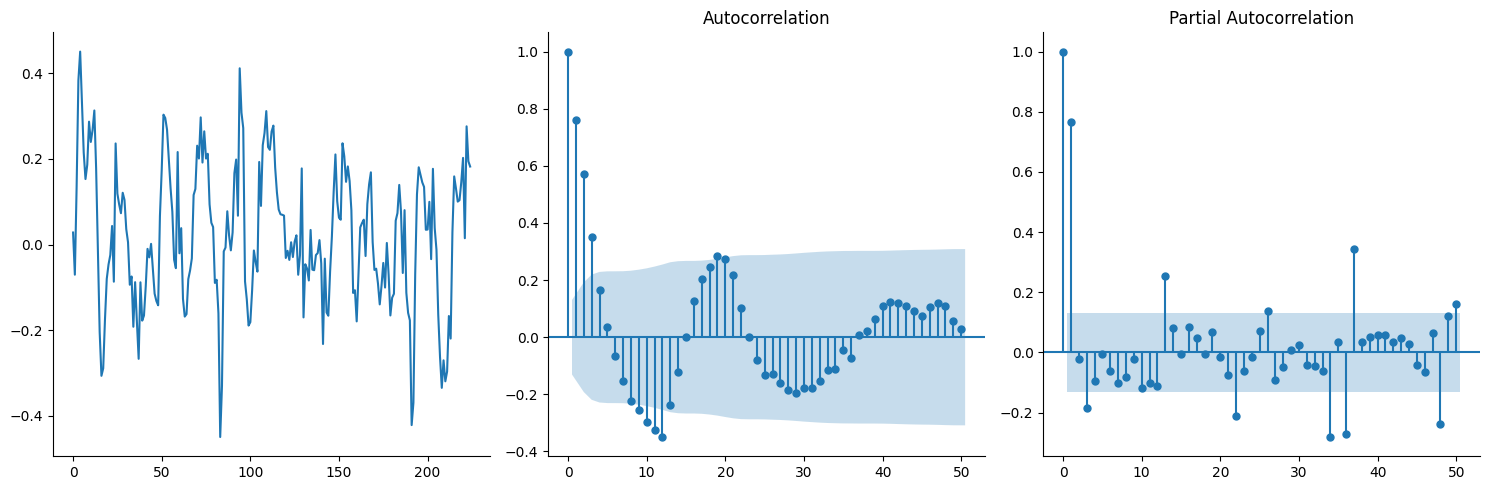

In [817]:
plots(multiplicative_diff_production_12, lags=50)

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.49197065192110045,
 '2. Mean Percentage Error (MPE)': -0.4806118635093448,
 '3. Root Mean Squared Error (RMSE)': 302.66217237031213,
 '4. Mean Error (ME)': -174.5193066924922,
 '5. Mean Absolute Error (MAE)': 174.5329387458211,
 '6. Correlation between the Actual and the Fo

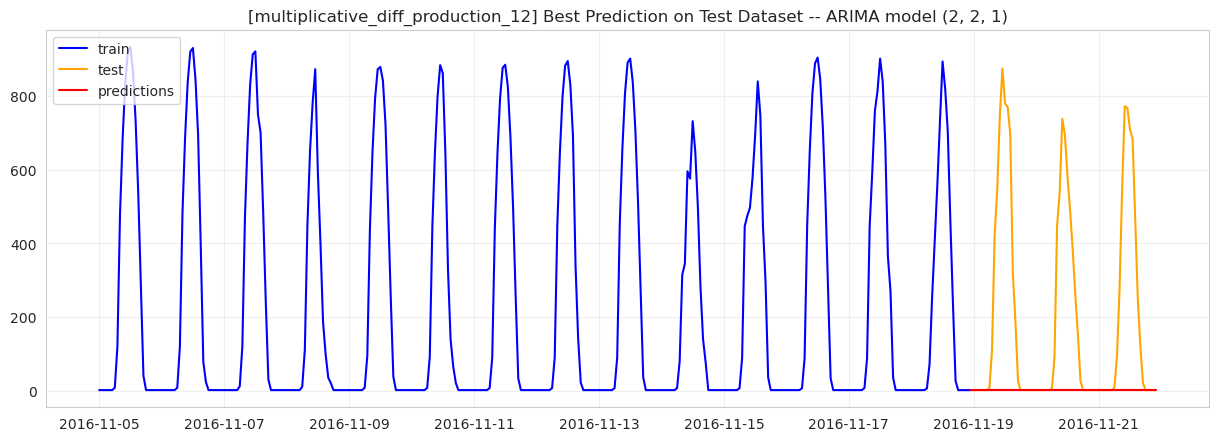

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (1, 1, 1)
{'1. Mean Absolute Percentage Error (MAPE)': 0.5022787768704121,
 '2. Mean Percentage Error (MPE)': -0.5022787768704121,
 '3. Root Mean Squared Error (RMSE)': 340.9500491196197,
 '4. Mean Error (ME)': -195.64040726817058,
 '5. Mean Absolute Error (MAE)': 195.64040726817058,
 '6. Correlation between the Actual and the Fo

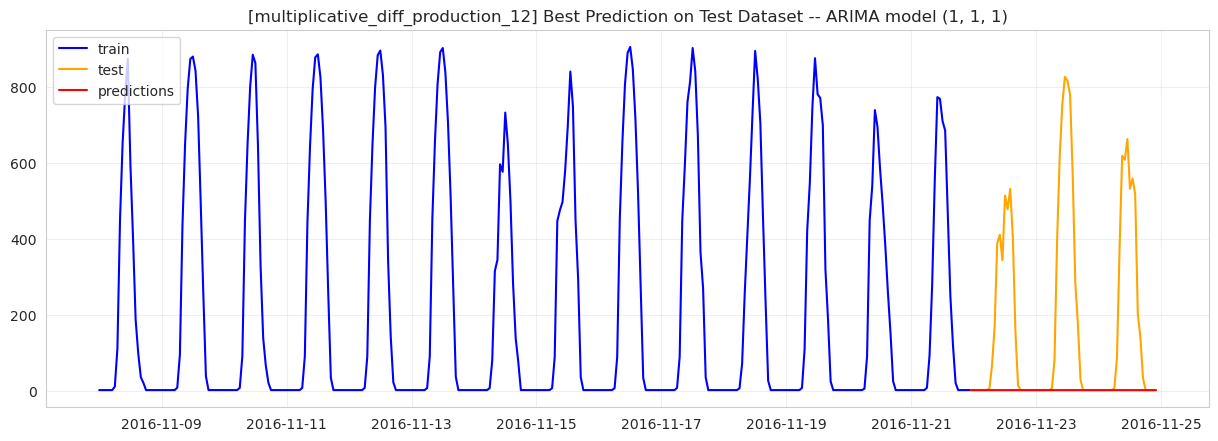

############################################################ AR Model ############################################################ 











############################################################ MA Model ############################################################ 











############################################################ ARMA Model ############################################################ 











############################################################ ARIMA Model ############################################################ 




 ==================== Forecast ARIMA Accuracy on Test Set ====================
Order (p, d, q) --  (2, 2, 2)
{'1. Mean Absolute Percentage Error (MAPE)': 0.500407793570513,
 '2. Mean Percentage Error (MPE)': -0.4769821298200876,
 '3. Root Mean Squared Error (RMSE)': 401.55752704890097,
 '4. Mean Error (ME)': -238.86097478565418,
 '5. Mean Absolute Error (MAE)': 238.88911972842138,
 '6. Correlation between the Actual and the Fo

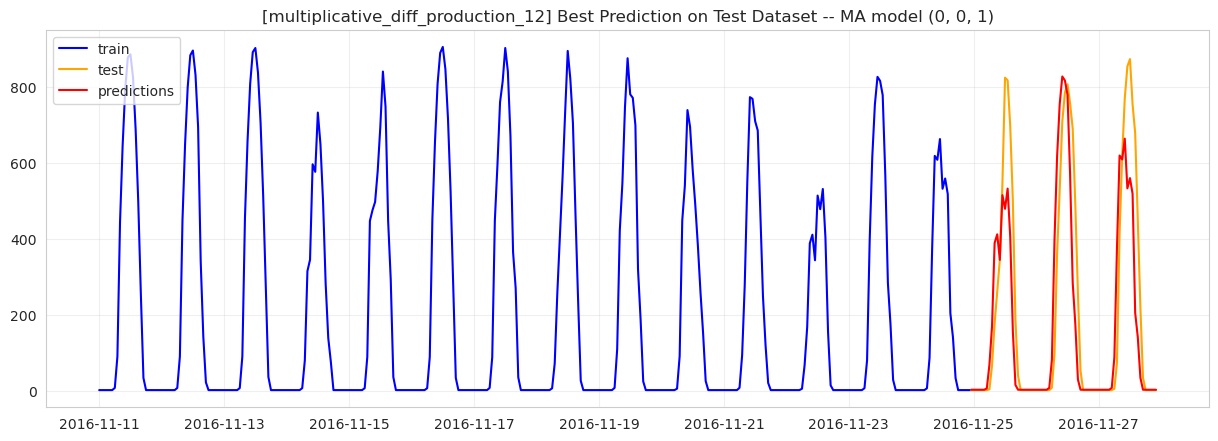

In [118]:
multiplicative_diff_production_12_results_df = test_ARIMA_models(hourly_radiation_reset_df, multiplicative_diff_production_12,
                                                          hourly_radiation_reset_df.Log_Radiation, 'multiplicative_diff_production_12',
                                                          show_plots=False, debug_mode=False)

<a id='conclusion'></a>
## Conclusion

### Best Forcasts of AR, MA, ARMA and ARIMA models (based on Cross-Validation)

In [123]:
total_results_df = pd.concat([
    additive_decomposed_radiation_results_df, multiplicative_decomposed_radiation_results_df,
    # additive_diff_production_1_results_df, multiplicative_diff_production_1_results_df,
    # additive_diff_production_12_results_df,
    multiplicative_diff_production_12_results_df
])
total_results_df

Iteration               Stationary_Series_Name   Model_Name Model_Orders  \
0         1        additive_decomposed_radiation   ARMA model    (1, 0, 1)   
1         2        additive_decomposed_radiation   ARMA model    (1, 0, 1)   
2         3        additive_decomposed_radiation   ARMA model    (4, 0, 4)   
0         1  multiplicative_decomposed_radiation   ARMA model    (1, 0, 1)   
1         2  multiplicative_decomposed_radiation   ARMA model    (3, 0, 4)   
2         3  multiplicative_decomposed_radiation   ARMA model    (2, 0, 4)   
0         1    multiplicative_diff_production_12  ARIMA model    (2, 2, 1)   
1         2    multiplicative_diff_production_12  ARIMA model    (1, 1, 1)   
2         3    multiplicative_diff_production_12     MA model    (0, 0, 1)   

   Mean Absolute Percentage Error (MAPE)  Mean Percentage Error (MPE)  \
0                               2.550840                    -2.327379   
1                               3.065801                    -1.500479   
2                               4.105581                    -3.543872   
0                               0.194843                     0.155162   
1                               0.272466                     0.256628   
2                               0.280240                     0.256183   
0                               0.491971                    -0.480612   
1                               0.502279                    -0.502279   
2                               0.532510                     0.358093   

   Root Mean Squared Error (RMSE)  
0                       66.828926  
1                       97.002888  
2                       89.179559  
0                       65.390592  
1                       92.464574  
2                      100.022562  
0                      302.662172  
1                      340.950049  
2                       98.372108

In my case, the best prediction was given by this model:

| Stationary_Series_Name | Model_Name | Model_Orders (p, d, q) | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| multiplicative_decomposed_production | ARMA model| "(4, 0, 3)" | 0.026988 | -0.009899 | 6.591711 |

Here we proved our hypothesis that multiplicative hypothesis will give the best forecast for period of 12 months. Based on cross-validation it gives the best forecasts on second and third iterations.
 Also model with such parameters is pretty close too -- additive_decomposed_production, AR model, "(4, 0, 0)"